# Colab check, Drive mount, etc

In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [2]:
import os
from google.colab import files

In [3]:
if IN_COLAB:
  # Mount the Google Drive at mount
  mount_path='/content/drive'
  print("Colab: mounting Google drive on ", mount_path)

  drive.mount(mount_path)

  # Switch to the directory on the Google Drive that you want to use
  drive_root = mount_path + "/MyDrive/hcv_seq_analysis"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

Colab: mounting Google drive on  /content/drive
Mounted at /content/drive

Colab: making sure  /content/drive/MyDrive/hcv_seq_analysis  exists.

Colab: Changing directory to  /content/drive/MyDrive/hcv_seq_analysis
/content/drive/MyDrive/hcv_seq_analysis


# Libraries (loading, installation, etc)

In [4]:
!pip install Biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 29.9 MB/s 


In [5]:
import re
import itertools
import datetime

from collections import Counter

import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns

from tqdm import tqdm

In [6]:
from Bio import Entrez, SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqUtils import GC

Entrez.email = 'vermaakhilkr01@gmail.com'

In [7]:
import scipy
import Bio
print(pd.__version__)
# print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(re.__version__)
print(Bio.__version__)

1.3.5
1.7.3
0.11.2
2.2.1
1.80


# Data collection

## LANL's HCV database

We searched for high quality HCV sequences in [LANL's HCV sequence database (PMID: 15377502)](https://hcv.lanl.gov/content/sequence/HCV/ToolsOutline.html) and downloaded a list of accession ids corresponding to those sequences (n=3983).

Filters used:
- Genotype- Any
- Subtype- Any
- Inclusion of recombinants
- Genomic region- Complete genome
- Exclusion of problematic sequences (Too many N's, Contaminant, Synthetic, Deletion, Tiny, Patent, H). As a result, 114 problematic sequences were excluded from the final list.
- Hosts- Any because there were only 6 sequences from Human hosts

In [8]:
idlist = [
    "AB016785",
    "AB030907",
    "AB031663",
    "AB047639",
    "AB047640",
    "AB047641",
    "AB047642",
    "AB047643",
    "AB047644",
    "AB047645",
    "AB049087",
    "AB049088",
    "AB049089",
    "AB049090",
    "AB049091",
    "AB049092",
    "AB049093",
    "AB049094",
    "AB049095",
    "AB049096",
    "AB049097",
    "AB049098",
    "AB049099",
    "AB049100",
    "AB049101",
    "AB080299",
    "AB119282",
    "AB154177",
    "AB154178",
    "AB154179",
    "AB154180",
    "AB154181",
    "AB154182",
    "AB154183",
    "AB154184",
    "AB154185",
    "AB154186",
    "AB154187",
    "AB154188",
    "AB154189",
    "AB154190",
    "AB154191",
    "AB154192",
    "AB154193",
    "AB154194",
    "AB154195",
    "AB154196",
    "AB154197",
    "AB154198",
    "AB154199",
    "AB154200",
    "AB154201",
    "AB154202",
    "AB154203",
    "AB154204",
    "AB154205",
    "AB154206",
    "AB191333",
    "AB249644",
    "AB426117",
    "AB429050",
    "AB435162",
    "AB442219",
    "AB442220",
    "AB442221",
    "AB442222",
    "AB520610",
    "AB559564",
    "AB622121",
    "AB661373",
    "AB661374",
    "AB661375",
    "AB661376",
    "AB661377",
    "AB661378",
    "AB661379",
    "AB661380",
    "AB661381",
    "AB661382",
    "AB661383",
    "AB661384",
    "AB661385",
    "AB661386",
    "AB661387",
    "AB661388",
    "AB661389",
    "AB661390",
    "AB661391",
    "AB661392",
    "AB661393",
    "AB661394",
    "AB661395",
    "AB661396",
    "AB661397",
    "AB661398",
    "AB661399",
    "AB661400",
    "AB661401",
    "AB661402",
    "AB661403",
    "AB661404",
    "AB661405",
    "AB661406",
    "AB661407",
    "AB661408",
    "AB661409",
    "AB661410",
    "AB661411",
    "AB661412",
    "AB661413",
    "AB661414",
    "AB661415",
    "AB661416",
    "AB661417",
    "AB661418",
    "AB661419",
    "AB661420",
    "AB661421",
    "AB661422",
    "AB661423",
    "AB661424",
    "AB661425",
    "AB661426",
    "AB661427",
    "AB661428",
    "AB661429",
    "AB661430",
    "AB661431",
    "AB661432",
    "AB677527",
    "AB677528",
    "AB677529",
    "AB677530",
    "AB677531",
    "AB677532",
    "AB677533",
    "AB690460",
    "AB690461",
    "AB691595",
    "AB691596",
    "AB691953",
    "AB779562",
    "AB779679",
    "AB792683",
    "AB795432",
    "AB828699",
    "AB828700",
    "AB828701",
    "AB828702",
    "AB828703",
    "AB828704",
    "AF009606",
    "AF011751",
    "AF011752",
    "AF011753",
    "AF046866",
    "AF054247",
    "AF054248",
    "AF054249",
    "AF054250",
    "AF054251",
    "AF054252",
    "AF054253",
    "AF054254",
    "AF054255",
    "AF054256",
    "AF054257",
    "AF054258",
    "AF054259",
    "AF064490",
    "AF139594",
    "AF165045",
    "AF165046",
    "AF165047",
    "AF165048",
    "AF165049",
    "AF165050",
    "AF165051",
    "AF165052",
    "AF165053",
    "AF165054",
    "AF165055",
    "AF165056",
    "AF165057",
    "AF165058",
    "AF165059",
    "AF165060",
    "AF165061",
    "AF165062",
    "AF165063",
    "AF165064",
    "AF169002",
    "AF169003",
    "AF169004",
    "AF169005",
    "AF176573",
    "AF177036",
    "AF207752",
    "AF207753",
    "AF207754",
    "AF207755",
    "AF207756",
    "AF207757",
    "AF207758",
    "AF207759",
    "AF207760",
    "AF207761",
    "AF207762",
    "AF207763",
    "AF207764",
    "AF207765",
    "AF207766",
    "AF207767",
    "AF207768",
    "AF207769",
    "AF207770",
    "AF207771",
    "AF207772",
    "AF207773",
    "AF207774",
    "AF208024",
    "AF238481",
    "AF238482",
    "AF238483",
    "AF238484",
    "AF238485",
    "AF238486",
    "AF271632",
    "AF290978",
    "AF313916",
    "AF333324",
    "AF356827",
    "AF483269",
    "AF511948",
    "AF511949",
    "AF511950",
    "AJ000009",
    "AJ132996",
    "AJ132997",
    "AJ238799",
    "AJ238800",
    "AJ278830",
    "AJ851228",
    "AM408911",
    "AM910652",
    "AY045702",
    "AY051292",
    "AY232730",
    "AY232731",
    "AY232732",
    "AY232733",
    "AY232734",
    "AY232735",
    "AY232736",
    "AY232737",
    "AY232738",
    "AY232739",
    "AY232740",
    "AY232741",
    "AY232742",
    "AY232743",
    "AY232744",
    "AY232745",
    "AY232746",
    "AY232747",
    "AY232748",
    "AY232749",
    "AY460204",
    "AY587016",
    "AY587844",
    "AY587845",
    "AY615798",
    "AY651061",
    "AY695436",
    "AY695437",
    "AY746460",
    "AY859526",
    "AY878650",
    "AY878651",
    "AY878652",
    "AY956463",
    "AY956464",
    "AY956465",
    "AY956466",
    "AY956467",
    "AY956468",
    "AY956469",
    "D00944",
    "D10749",
    "D10750",
    "D10934",
    "D10988",
    "D11168",
    "D11355",
    "D13558",
    "D14484",
    "D14853",
    "D17763",
    "D28917",
    "D30613",
    "D45172",
    "D49374",
    "D50409",
    "D50480",
    "D50481",
    "D50482",
    "D50483",
    "D50484",
    "D50485",
    "D63821",
    "D63822",
    "D63857",
    "D84262",
    "D84263",
    "D84264",
    "D84265",
    "D85516",
    "D89815",
    "D89872",
    "D90208",
    "DQ071885",
    "DQ155560",
    "DQ155561",
    "DQ244140",
    "DQ244141",
    "DQ278891",
    "DQ278892",
    "DQ278893",
    "DQ278894",
    "DQ314805",
    "DQ314806",
    "DQ364460",
    "DQ418782",
    "DQ418783",
    "DQ418784",
    "DQ418785",
    "DQ418786",
    "DQ418787",
    "DQ418788",
    "DQ418789",
    "DQ430811",
    "DQ430812",
    "DQ430813",
    "DQ430814",
    "DQ430815",
    "DQ430817",
    "DQ430819",
    "DQ430820",
    "DQ437509",
    "DQ480512",
    "DQ480513",
    "DQ480514",
    "DQ480515",
    "DQ480516",
    "DQ480517",
    "DQ480518",
    "DQ480519",
    "DQ480520",
    "DQ480521",
    "DQ480522",
    "DQ480523",
    "DQ480524",
    "DQ516083",
    "DQ516084",
    "DQ835760",
    "DQ835761",
    "DQ835762",
    "DQ835763",
    "DQ835764",
    "DQ835765",
    "DQ835766",
    "DQ835767",
    "DQ835768",
    "DQ835769",
    "DQ835770",
    "DQ838739",
    "DQ838740",
    "DQ838741",
    "DQ838742",
    "DQ838743",
    "DQ838744",
    "DQ838745",
    "DQ889251",
    "DQ889252",
    "DQ889253",
    "DQ889254",
    "DQ889255",
    "DQ889256",
    "DQ889257",
    "DQ889258",
    "DQ889259",
    "DQ889260",
    "DQ889261",
    "DQ889262",
    "DQ889263",
    "DQ889264",
    "DQ889265",
    "DQ889266",
    "DQ889267",
    "DQ889268",
    "DQ889269",
    "DQ889270",
    "DQ889271",
    "DQ889272",
    "DQ889273",
    "DQ889274",
    "DQ889275",
    "DQ889276",
    "DQ889277",
    "DQ889278",
    "DQ889279",
    "DQ889280",
    "DQ889281",
    "DQ889282",
    "DQ889283",
    "DQ889284",
    "DQ889286",
    "DQ889287",
    "DQ889288",
    "DQ889289",
    "DQ889290",
    "DQ889291",
    "DQ889292",
    "DQ889293",
    "DQ889294",
    "DQ889295",
    "DQ889296",
    "DQ889297",
    "DQ889298",
    "DQ889299",
    "DQ889300",
    "DQ889301",
    "DQ889302",
    "DQ889303",
    "DQ889304",
    "DQ889305",
    "DQ889306",
    "DQ889307",
    "DQ889308",
    "DQ889309",
    "DQ889310",
    "DQ889311",
    "DQ889312",
    "DQ889313",
    "DQ889314",
    "DQ889315",
    "DQ889316",
    "DQ889317",
    "DQ889318",
    "DQ889319",
    "DQ889320",
    "DQ889321",
    "DQ988073",
    "DQ988074",
    "DQ988075",
    "DQ988076",
    "DQ988077",
    "DQ988078",
    "DQ988079",
    "EF026073",
    "EF032883",
    "EF032884",
    "EF032885",
    "EF032886",
    "EF032887",
    "EF032889",
    "EF032890",
    "EF032891",
    "EF032892",
    "EF032893",
    "EF032894",
    "EF032895",
    "EF032896",
    "EF032898",
    "EF032899",
    "EF032900",
    "EF108306",
    "EF407411",
    "EF407412",
    "EF407413",
    "EF407414",
    "EF407415",
    "EF407416",
    "EF407417",
    "EF407418",
    "EF407419",
    "EF407420",
    "EF407421",
    "EF407422",
    "EF407423",
    "EF407424",
    "EF407425",
    "EF407426",
    "EF407427",
    "EF407428",
    "EF407429",
    "EF407430",
    "EF407431",
    "EF407432",
    "EF407433",
    "EF407434",
    "EF407435",
    "EF407436",
    "EF407437",
    "EF407438",
    "EF407439",
    "EF407440",
    "EF407441",
    "EF407442",
    "EF407443",
    "EF407444",
    "EF407445",
    "EF407446",
    "EF407447",
    "EF407448",
    "EF407449",
    "EF407450",
    "EF407451",
    "EF407452",
    "EF407453",
    "EF407454",
    "EF407455",
    "EF407456",
    "EF407457",
    "EF407458",
    "EF407459",
    "EF407460",
    "EF407461",
    "EF407462",
    "EF407463",
    "EF407464",
    "EF407465",
    "EF407466",
    "EF407467",
    "EF407468",
    "EF407469",
    "EF407470",
    "EF407471",
    "EF407472",
    "EF407473",
    "EF407474",
    "EF407475",
    "EF407476",
    "EF407477",
    "EF407478",
    "EF407479",
    "EF407480",
    "EF407481",
    "EF407482",
    "EF407483",
    "EF407484",
    "EF407485",
    "EF407486",
    "EF407487",
    "EF407488",
    "EF407489",
    "EF407490",
    "EF407491",
    "EF407492",
    "EF407493",
    "EF407494",
    "EF407495",
    "EF407496",
    "EF407497",
    "EF407498",
    "EF407499",
    "EF407500",
    "EF407501",
    "EF407502",
    "EF407503",
    "EF407504",
    "EF424625",
    "EF424626",
    "EF424627",
    "EF424628",
    "EF424629",
    "EF589160",
    "EF589161",
    "EF621489",
    "EF632069",
    "EF632070",
    "EF632071",
    "EF638081",
    "EU155213",
    "EU155214",
    "EU155215",
    "EU155216",
    "EU155217",
    "EU155218",
    "EU155219",
    "EU155220",
    "EU155221",
    "EU155222",
    "EU155223",
    "EU155224",
    "EU155225",
    "EU155226",
    "EU155227",
    "EU155228",
    "EU155229",
    "EU155230",
    "EU155231",
    "EU155232",
    "EU155233",
    "EU155234",
    "EU155235",
    "EU155236",
    "EU155237",
    "EU155238",
    "EU155239",
    "EU155240",
    "EU155241",
    "EU155242",
    "EU155243",
    "EU155244",
    "EU155245",
    "EU155246",
    "EU155247",
    "EU155248",
    "EU155249",
    "EU155250",
    "EU155251",
    "EU155252",
    "EU155253",
    "EU155254",
    "EU155255",
    "EU155256",
    "EU155257",
    "EU155258",
    "EU155259",
    "EU155260",
    "EU155261",
    "EU155262",
    "EU155263",
    "EU155264",
    "EU155265",
    "EU155266",
    "EU155267",
    "EU155268",
    "EU155269",
    "EU155270",
    "EU155271",
    "EU155272",
    "EU155273",
    "EU155274",
    "EU155275",
    "EU155276",
    "EU155277",
    "EU155278",
    "EU155279",
    "EU155280",
    "EU155281",
    "EU155282",
    "EU155283",
    "EU155284",
    "EU155285",
    "EU155286",
    "EU155287",
    "EU155288",
    "EU155289",
    "EU155290",
    "EU155291",
    "EU155292",
    "EU155293",
    "EU155294",
    "EU155295",
    "EU155296",
    "EU155297",
    "EU155298",
    "EU155299",
    "EU155300",
    "EU155301",
    "EU155302",
    "EU155303",
    "EU155304",
    "EU155305",
    "EU155306",
    "EU155307",
    "EU155308",
    "EU155309",
    "EU155310",
    "EU155311",
    "EU155312",
    "EU155313",
    "EU155314",
    "EU155315",
    "EU155316",
    "EU155317",
    "EU155318",
    "EU155319",
    "EU155320",
    "EU155321",
    "EU155322",
    "EU155323",
    "EU155324",
    "EU155325",
    "EU155326",
    "EU155327",
    "EU155328",
    "EU155329",
    "EU155330",
    "EU155331",
    "EU155332",
    "EU155333",
    "EU155334",
    "EU155335",
    "EU155336",
    "EU155337",
    "EU155338",
    "EU155339",
    "EU155340",
    "EU155341",
    "EU155342",
    "EU155343",
    "EU155344",
    "EU155345",
    "EU155346",
    "EU155347",
    "EU155348",
    "EU155349",
    "EU155350",
    "EU155351",
    "EU155352",
    "EU155353",
    "EU155354",
    "EU155355",
    "EU155356",
    "EU155357",
    "EU155358",
    "EU155359",
    "EU155360",
    "EU155361",
    "EU155362",
    "EU155363",
    "EU155364",
    "EU155365",
    "EU155366",
    "EU155367",
    "EU155368",
    "EU155369",
    "EU155370",
    "EU155371",
    "EU155372",
    "EU155373",
    "EU155374",
    "EU155375",
    "EU155376",
    "EU155377",
    "EU155378",
    "EU155379",
    "EU155380",
    "EU155381",
    "EU155382",
    "EU158186",
    "EU234061",
    "EU234062",
    "EU234063",
    "EU234064",
    "EU234065",
    "EU239713",
    "EU239714",
    "EU239715",
    "EU239716",
    "EU246930",
    "EU246931",
    "EU246932",
    "EU246933",
    "EU246934",
    "EU246935",
    "EU246936",
    "EU246937",
    "EU246938",
    "EU246939",
    "EU246940",
    "EU250017",
    "EU255927",
    "EU255928",
    "EU255929",
    "EU255930",
    "EU255931",
    "EU255932",
    "EU255933",
    "EU255934",
    "EU255935",
    "EU255936",
    "EU255937",
    "EU255938",
    "EU255939",
    "EU255940",
    "EU255941",
    "EU255942",
    "EU255943",
    "EU255944",
    "EU255945",
    "EU255946",
    "EU255947",
    "EU255948",
    "EU255949",
    "EU255950",
    "EU255951",
    "EU255952",
    "EU255953",
    "EU255954",
    "EU255955",
    "EU255956",
    "EU255957",
    "EU255958",
    "EU255959",
    "EU255960",
    "EU255961",
    "EU255962",
    "EU255963",
    "EU255964",
    "EU255965",
    "EU255966",
    "EU255967",
    "EU255968",
    "EU255969",
    "EU255970",
    "EU255971",
    "EU255973",
    "EU255974",
    "EU255975",
    "EU255976",
    "EU255977",
    "EU255978",
    "EU255979",
    "EU255980",
    "EU255981",
    "EU255982",
    "EU255983",
    "EU255984",
    "EU255985",
    "EU255986",
    "EU255987",
    "EU255988",
    "EU255989",
    "EU255990",
    "EU255991",
    "EU255992",
    "EU255993",
    "EU255994",
    "EU255995",
    "EU255996",
    "EU255997",
    "EU255998",
    "EU255999",
    "EU256000",
    "EU256001",
    "EU256002",
    "EU256003",
    "EU256004",
    "EU256005",
    "EU256006",
    "EU256007",
    "EU256008",
    "EU256009",
    "EU256010",
    "EU256011",
    "EU256012",
    "EU256013",
    "EU256014",
    "EU256015",
    "EU256016",
    "EU256017",
    "EU256018",
    "EU256019",
    "EU256020",
    "EU256021",
    "EU256022",
    "EU256023",
    "EU256024",
    "EU256025",
    "EU256026",
    "EU256027",
    "EU256028",
    "EU256029",
    "EU256030",
    "EU256031",
    "EU256032",
    "EU256033",
    "EU256034",
    "EU256035",
    "EU256036",
    "EU256037",
    "EU256038",
    "EU256039",
    "EU256040",
    "EU256041",
    "EU256042",
    "EU256043",
    "EU256044",
    "EU256045",
    "EU256046",
    "EU256047",
    "EU256048",
    "EU256049",
    "EU256050",
    "EU256051",
    "EU256052",
    "EU256053",
    "EU256054",
    "EU256055",
    "EU256056",
    "EU256057",
    "EU256058",
    "EU256059",
    "EU256060",
    "EU256061",
    "EU256062",
    "EU256064",
    "EU256065",
    "EU256066",
    "EU256067",
    "EU256068",
    "EU256069",
    "EU256070",
    "EU256071",
    "EU256072",
    "EU256073",
    "EU256074",
    "EU256075",
    "EU256076",
    "EU256077",
    "EU256078",
    "EU256079",
    "EU256080",
    "EU256081",
    "EU256082",
    "EU256083",
    "EU256084",
    "EU256085",
    "EU256086",
    "EU256087",
    "EU256088",
    "EU256089",
    "EU256090",
    "EU256091",
    "EU256092",
    "EU256094",
    "EU256095",
    "EU256096",
    "EU256097",
    "EU256098",
    "EU256099",
    "EU256100",
    "EU256101",
    "EU256102",
    "EU256103",
    "EU256104",
    "EU256105",
    "EU256106",
    "EU256107",
    "EU260395",
    "EU260396",
    "EU362876",
    "EU362877",
    "EU362878",
    "EU362879",
    "EU362880",
    "EU362881",
    "EU362882",
    "EU362883",
    "EU362884",
    "EU362885",
    "EU362886",
    "EU362887",
    "EU362888",
    "EU362889",
    "EU362890",
    "EU362891",
    "EU362892",
    "EU362893",
    "EU362894",
    "EU362895",
    "EU362896",
    "EU362897",
    "EU362898",
    "EU362899",
    "EU362900",
    "EU362901",
    "EU362902",
    "EU362903",
    "EU362904",
    "EU362905",
    "EU362906",
    "EU362907",
    "EU362908",
    "EU362909",
    "EU362910",
    "EU362911",
    "EU392169",
    "EU392170",
    "EU392171",
    "EU392172",
    "EU392173",
    "EU392174",
    "EU392175",
    "EU408326",
    "EU408327",
    "EU408328",
    "EU408329",
    "EU408330",
    "EU408331",
    "EU408332",
    "EU482831",
    "EU482832",
    "EU482833",
    "EU482834",
    "EU482835",
    "EU482836",
    "EU482837",
    "EU482838",
    "EU482839",
    "EU482840",
    "EU482841",
    "EU482842",
    "EU482843",
    "EU482844",
    "EU482845",
    "EU482846",
    "EU482847",
    "EU482848",
    "EU482849",
    "EU482850",
    "EU482852",
    "EU482853",
    "EU482854",
    "EU482855",
    "EU482856",
    "EU482857",
    "EU482858",
    "EU482859",
    "EU482860",
    "EU482861",
    "EU482862",
    "EU482863",
    "EU482864",
    "EU482865",
    "EU482866",
    "EU482867",
    "EU482868",
    "EU482869",
    "EU482870",
    "EU482871",
    "EU482872",
    "EU482873",
    "EU482874",
    "EU482875",
    "EU482876",
    "EU482877",
    "EU482878",
    "EU482879",
    "EU482880",
    "EU482881",
    "EU482882",
    "EU482883",
    "EU482884",
    "EU482885",
    "EU482886",
    "EU482887",
    "EU482888",
    "EU482889",
    "EU529676",
    "EU529677",
    "EU529678",
    "EU529679",
    "EU529680",
    "EU529681",
    "EU529682",
    "EU569722",
    "EU569723",
    "EU595697",
    "EU595698",
    "EU595699",
    "EU643834",
    "EU643835",
    "EU643836",
    "EU660383",
    "EU660384",
    "EU660385",
    "EU660386",
    "EU660387",
    "EU660388",
    "EU677247",
    "EU677248",
    "EU677249",
    "EU677250",
    "EU677251",
    "EU677252",
    "EU677253",
    "EU677254",
    "EU677255",
    "EU677256",
    "EU677257",
    "EU677258",
    "EU687193",
    "EU687194",
    "EU687195",
    "EU781746",
    "EU781747",
    "EU781748",
    "EU781749",
    "EU781750",
    "EU781751",
    "EU781752",
    "EU781753",
    "EU781754",
    "EU781755",
    "EU781756",
    "EU781757",
    "EU781758",
    "EU781759",
    "EU781760",
    "EU781761",
    "EU781762",
    "EU781763",
    "EU781764",
    "EU781765",
    "EU781766",
    "EU781767",
    "EU781768",
    "EU781769",
    "EU781770",
    "EU781771",
    "EU781772",
    "EU781773",
    "EU781774",
    "EU781775",
    "EU781776",
    "EU781777",
    "EU781778",
    "EU781779",
    "EU781780",
    "EU781781",
    "EU781782",
    "EU781783",
    "EU781784",
    "EU781785",
    "EU781786",
    "EU781787",
    "EU781788",
    "EU781789",
    "EU781790",
    "EU781791",
    "EU781792",
    "EU781793",
    "EU781794",
    "EU781795",
    "EU781796",
    "EU781797",
    "EU781798",
    "EU781799",
    "EU781800",
    "EU781801",
    "EU781802",
    "EU781803",
    "EU781804",
    "EU781805",
    "EU781806",
    "EU781807",
    "EU781808",
    "EU781809",
    "EU781810",
    "EU781811",
    "EU781812",
    "EU781813",
    "EU781814",
    "EU781815",
    "EU781816",
    "EU781817",
    "EU781818",
    "EU781819",
    "EU781820",
    "EU781821",
    "EU781822",
    "EU781823",
    "EU781824",
    "EU781825",
    "EU781826",
    "EU781827",
    "EU781828",
    "EU781829",
    "EU781830",
    "EU781831",
    "EU781832",
    "EU798760",
    "EU798761",
    "EU857431",
    "EU862823",
    "EU862824",
    "EU862826",
    "EU862827",
    "EU862828",
    "EU862829",
    "EU862830",
    "EU862831",
    "EU862832",
    "EU862833",
    "EU862834",
    "EU862835",
    "EU862836",
    "EU862837",
    "EU862838",
    "EU862839",
    "EU862840",
    "EU862841",
    "FJ024086",
    "FJ024087",
    "FJ024274",
    "FJ024275",
    "FJ024276",
    "FJ024277",
    "FJ024278",
    "FJ024279",
    "FJ024280",
    "FJ024281",
    "FJ024282",
    "FJ025854",
    "FJ025855",
    "FJ025856",
    "FJ181999",
    "FJ182000",
    "FJ182001",
    "FJ205867",
    "FJ205868",
    "FJ205869",
    "FJ390394",
    "FJ390395",
    "FJ390396",
    "FJ390397",
    "FJ390398",
    "FJ390399",
    "FJ407092",
    "FJ410172",
    "FJ435090",
    "FJ462431",
    "FJ462432",
    "FJ462433",
    "FJ462434",
    "FJ462435",
    "FJ462436",
    "FJ462437",
    "FJ462438",
    "FJ462439",
    "FJ462440",
    "FJ462441",
    "FJ478453",
    "FJ839869",
    "FJ839870",
    "FN435993",
    "FN666428",
    "FN666429",
    "GQ149768",
    "GQ275355",
    "GQ356200",
    "GQ356201",
    "GQ356202",
    "GQ356203",
    "GQ356204",
    "GQ356205",
    "GQ356206",
    "GQ356207",
    "GQ356208",
    "GQ356209",
    "GQ356210",
    "GQ356211",
    "GQ356212",
    "GQ356213",
    "GQ356214",
    "GQ356215",
    "GQ356216",
    "GQ356217",
    "GU133617",
    "GU294484",
    "GU451218",
    "GU451219",
    "GU451220",
    "GU451221",
    "GU451222",
    "GU451223",
    "GU451224",
    "GU814263",
    "GU814265",
    "HM777358",
    "HM777359",
    "HQ110091",
    "HQ537005",
    "HQ537006",
    "HQ537007",
    "HQ537008",
    "HQ537009",
    "HQ639936",
    "HQ639937",
    "HQ639938",
    "HQ639939",
    "HQ639940",
    "HQ639941",
    "HQ639942",
    "HQ639943",
    "HQ639944",
    "HQ639945",
    "HQ639946",
    "HQ639947",
    "HQ719473",
    "HQ738645",
    "HQ850278",
    "HQ850279",
    "HQ850280",
    "HQ850281",
    "HQ850282",
    "HQ850283",
    "HQ850284",
    "HQ850285",
    "HQ850286",
    "HQ850287",
    "HQ850288",
    "HQ850289",
    "HQ850290",
    "HQ912953",
    "HQ912954",
    "HQ912955",
    "HQ912956",
    "HQ912957",
    "HQ912958",
    "HQ912959",
    "JF509175",
    "JF509176",
    "JF509177",
    "JF735110",
    "JF735111",
    "JF735112",
    "JF735113",
    "JF735114",
    "JF735115",
    "JF735116",
    "JF735117",
    "JF735118",
    "JF735119",
    "JF735120",
    "JF735121",
    "JF735122",
    "JF735123",
    "JF735124",
    "JF735125",
    "JF735126",
    "JF735127",
    "JF735128",
    "JF735129",
    "JF735130",
    "JF735131",
    "JF735132",
    "JF735133",
    "JF735134",
    "JF735135",
    "JF735136",
    "JF735137",
    "JF735138",
    "JF779679",
    "JN120912",
    "JN588558",
    "JN714194",
    "JQ061779",
    "JQ061780",
    "JQ061781",
    "JQ061782",
    "JQ061783",
    "JQ061784",
    "JQ061785",
    "JQ061786",
    "JQ061787",
    "JQ065709",
    "JQ434001",
    "JQ434002",
    "JQ434003",
    "JQ434004",
    "JQ434005",
    "JQ434006",
    "JQ434007",
    "JQ434008",
    "JQ717254",
    "JQ717255",
    "JQ717256",
    "JQ717257",
    "JQ717258",
    "JQ717259",
    "JQ717260",
    "JQ745651",
    "JQ914271",
    "JQ914272",
    "JQ914273",
    "JQ914274",
    "JX014307",
    "JX183549",
    "JX183550",
    "JX183551",
    "JX183552",
    "JX183553",
    "JX183554",
    "JX183555",
    "JX183556",
    "JX183557",
    "JX183558",
    "JX227949",
    "JX227950",
    "JX227951",
    "JX227952",
    "JX227953",
    "JX227954",
    "JX227955",
    "JX227956",
    "JX227957",
    "JX227958",
    "JX227959",
    "JX227960",
    "JX227961",
    "JX227962",
    "JX227963",
    "JX227964",
    "JX227965",
    "JX227966",
    "JX227967",
    "JX227968",
    "JX227969",
    "JX227970",
    "JX227971",
    "JX227972",
    "JX227973",
    "JX227974",
    "JX227975",
    "JX227976",
    "JX227977",
    "JX227978",
    "JX227979",
    "JX463525",
    "JX463526",
    "JX463527",
    "JX463528",
    "JX463529",
    "JX463530",
    "JX463531",
    "JX463532",
    "JX463533",
    "JX463534",
    "JX463535",
    "JX463536",
    "JX463537",
    "JX463538",
    "JX463539",
    "JX463540",
    "JX463541",
    "JX463542",
    "JX463543",
    "JX463544",
    "JX463545",
    "JX463546",
    "JX463547",
    "JX463548",
    "JX463549",
    "JX463550",
    "JX463551",
    "JX463552",
    "JX463553",
    "JX463554",
    "JX463555",
    "JX463556",
    "JX463557",
    "JX463558",
    "JX463559",
    "JX463560",
    "JX463561",
    "JX463562",
    "JX463563",
    "JX463564",
    "JX463565",
    "JX463566",
    "JX463567",
    "JX463568",
    "JX463569",
    "JX463570",
    "JX463571",
    "JX463572",
    "JX463573",
    "JX463574",
    "JX463575",
    "JX463576",
    "JX463577",
    "JX463578",
    "JX463579",
    "JX463580",
    "JX463581",
    "JX463582",
    "JX463583",
    "JX463584",
    "JX463585",
    "JX463586",
    "JX463587",
    "JX463588",
    "JX463589",
    "JX463590",
    "JX463591",
    "JX463592",
    "JX463593",
    "JX463594",
    "JX463595",
    "JX463596",
    "JX463597",
    "JX463598",
    "JX463599",
    "JX463600",
    "JX463601",
    "JX463602",
    "JX463603",
    "JX463604",
    "JX463605",
    "JX463606",
    "JX463607",
    "JX463608",
    "JX463609",
    "JX463610",
    "JX463611",
    "JX463612",
    "JX463613",
    "JX463614",
    "JX463615",
    "JX463616",
    "JX463617",
    "JX463618",
    "JX463619",
    "JX463620",
    "JX463621",
    "JX463622",
    "JX463623",
    "JX463624",
    "JX463625",
    "JX463626",
    "JX463627",
    "JX463628",
    "JX463629",
    "JX463630",
    "JX463631",
    "JX463632",
    "JX463633",
    "JX463634",
    "JX463635",
    "JX463636",
    "JX463637",
    "JX463638",
    "JX463639",
    "JX463640",
    "JX463641",
    "JX472005",
    "JX472006",
    "JX472007",
    "JX472008",
    "JX472009",
    "JX472010",
    "JX472011",
    "JX472012",
    "JX472013",
    "KC155254",
    "KC191671",
    "KC197226",
    "KC197227",
    "KC197228",
    "KC197229",
    "KC197230",
    "KC197231",
    "KC197232",
    "KC197233",
    "KC197234",
    "KC197235",
    "KC197236",
    "KC197237",
    "KC197238",
    "KC197239",
    "KC197240",
    "KC248193",
    "KC248194",
    "KC248195",
    "KC248196",
    "KC248197",
    "KC248198",
    "KC248199",
    "KC283194",
    "KC439481",
    "KC439482",
    "KC439483",
    "KC439484",
    "KC439485",
    "KC439486",
    "KC439487",
    "KC439488",
    "KC439489",
    "KC439490",
    "KC439491",
    "KC439492",
    "KC439493",
    "KC439494",
    "KC439495",
    "KC439496",
    "KC439497",
    "KC439498",
    "KC439499",
    "KC439500",
    "KC439501",
    "KC439502",
    "KC439503",
    "KC439504",
    "KC439505",
    "KC439506",
    "KC439507",
    "KC439508",
    "KC439509",
    "KC439510",
    "KC439511",
    "KC439512",
    "KC439513",
    "KC439514",
    "KC439515",
    "KC439516",
    "KC439517",
    "KC439518",
    "KC439519",
    "KC439520",
    "KC439521",
    "KC439522",
    "KC439523",
    "KC439524",
    "KC439525",
    "KC439526",
    "KC439527",
    "KC767829",
    "KC767830",
    "KC767831",
    "KC767832",
    "KC767833",
    "KC767834",
    "KC844037",
    "KC844038",
    "KC844039",
    "KC844040",
    "KC844041",
    "KC844042",
    "KC844043",
    "KC844044",
    "KC844045",
    "KC844046",
    "KC844047",
    "KC844048",
    "KC844049",
    "KC844050",
    "KC844051",
    "KC844052",
    "KC967476",
    "KC967477",
    "KC967478",
    "KC967479",
    "KF035123",
    "KF035124",
    "KF035125",
    "KF035126",
    "KF035127",
    "KF373567",
    "KF676351",
    "KF676352",
    "KF700370",
    "KJ437295",
    "KJ437300",
    "KJ437342",
    "KJ439767",
    "KJ439768",
    "KJ439769",
    "KJ439770",
    "KJ439771",
    "KJ439772",
    "KJ439773",
    "KJ439774",
    "KJ439775",
    "KJ439776",
    "KJ439777",
    "KJ439778",
    "KJ439779",
    "KJ439780",
    "KJ439781",
    "KJ439782",
    "KJ470612",
    "KJ470613",
    "KJ470614",
    "KJ470615",
    "KJ470616",
    "KJ470617",
    "KJ470618",
    "KJ470619",
    "KJ470620",
    "KJ470621",
    "KJ470622",
    "KJ470623",
    "KJ470624",
    "KJ470625",
    "KJ567644",
    "KJ567645",
    "KJ567646",
    "KJ567647",
    "KJ567648",
    "KJ567649",
    "KJ567650",
    "KJ567651",
    "KJ567652",
    "KJ678744",
    "KJ678745",
    "KJ678746",
    "KJ678747",
    "KJ678748",
    "KJ678749",
    "KJ678750",
    "KJ678751",
    "KJ678752",
    "KJ678753",
    "KJ678754",
    "KJ678755",
    "KJ678756",
    "KJ678757",
    "KJ678758",
    "KJ678759",
    "KJ678760",
    "KJ678761",
    "KJ678762",
    "KJ678763",
    "KJ678764",
    "KJ678765",
    "KJ678766",
    "KJ678767",
    "KJ678768",
    "KJ678769",
    "KJ678770",
    "KJ678771",
    "KJ678772",
    "KJ678773",
    "KJ678774",
    "KJ678775",
    "KJ678776",
    "KJ678777",
    "KJ678778",
    "KJ678779",
    "KJ678780",
    "KJ678781",
    "KJ678782",
    "KJ678783",
    "KJ678784",
    "KJ678785",
    "KJ678786",
    "KJ678787",
    "KJ678788",
    "KJ678789",
    "KJ678790",
    "KJ678791",
    "KJ678792",
    "KJ678793",
    "KJ678794",
    "KJ678795",
    "KJ678796",
    "KJ678797",
    "KJ678798",
    "KJ678799",
    "KJ678800",
    "KJ678801",
    "KJ678802",
    "KJ678803",
    "KJ678804",
    "KJ678805",
    "KJ678806",
    "KJ678807",
    "KJ678808",
    "KJ678809",
    "KJ678810",
    "KJ678811",
    "KJ678812",
    "KJ678813",
    "KJ678814",
    "KJ678815",
    "KJ678816",
    "KJ678817",
    "KJ679443",
    "KJ679444",
    "KJ925146",
    "KJ925147",
    "KJ925148",
    "KJ925149",
    "KM043272",
    "KM043273",
    "KM043274",
    "KM043275",
    "KM043276",
    "KM043277",
    "KM043278",
    "KM043279",
    "KM043280",
    "KM043281",
    "KM043282",
    "KM043283",
    "KM043284",
    "KM043285",
    "KM102760",
    "KM102761",
    "KM102762",
    "KM102763",
    "KM102764",
    "KM102766",
    "KM102767",
    "KM102768",
    "KM102769",
    "KM102770",
    "KM252779",
    "KM252780",
    "KM252781",
    "KM252782",
    "KM252783",
    "KM252784",
    "KM252785",
    "KM252786",
    "KM252787",
    "KM252788",
    "KM252789",
    "KM252790",
    "KM252791",
    "KM252792",
    "KM252793",
    "KM252794",
    "KM252795",
    "KM252796",
    "KM252797",
    "KM252798",
    "KM252799",
    "KM252800",
    "KM277568",
    "KM277569",
    "KM277570",
    "KM277571",
    "KM277572",
    "KM277573",
    "KM277574",
    "KM277575",
    "KM277576",
    "KM277577",
    "KM277578",
    "KM277579",
    "KM277580",
    "KM277581",
    "KM349851",
    "KM495736",
    "KM504109",
    "KM504110",
    "KM504111",
    "KM504112",
    "KM504113",
    "KM504114",
    "KM504115",
    "KM504116",
    "KM504117",
    "KM504118",
    "KM504119",
    "KM504120",
    "KM504121",
    "KM504122",
    "KM504123",
    "KM504124",
    "KM587614",
    "KM587615",
    "KM587616",
    "KM587617",
    "KM587618",
    "KM587620",
    "KM587621",
    "KM587622",
    "KM587623",
    "KM587624",
    "KM587625",
    "KM587626",
    "KM587627",
    "KM587628",
    "KM587629",
    "KM587630",
    "KP721475",
    "KR870888",
    "KT595242",
    "KT734516",
    "KT734517",
    "KT734518",
    "KT734519",
    "KT734520",
    "KT734521",
    "KT734522",
    "KT734523",
    "KT734524",
    "KT734525",
    "KT734526",
    "KT734527",
    "KT734528",
    "KT734529",
    "KT734530",
    "KT734531",
    "KT734532",
    "KT734533",
    "KT734534",
    "KT734535",
    "KT734536",
    "KT734537",
    "KT734538",
    "KT734539",
    "KT734540",
    "KT734541",
    "KT734542",
    "KT734543",
    "KT734544",
    "KT734545",
    "KT734546",
    "KT734547",
    "KT734548",
    "KT734549",
    "KT734550",
    "KT734551",
    "KT734552",
    "KT734553",
    "KT734554",
    "KT734555",
    "KT734556",
    "KT734557",
    "KT734558",
    "KT734559",
    "KT734560",
    "KT734561",
    "KT734562",
    "KT734563",
    "KT734564",
    "KT734565",
    "KT734566",
    "KT734567",
    "KT734568",
    "KT734569",
    "KT734570",
    "KT734571",
    "KT734572",
    "KT734573",
    "KT734574",
    "KT734575",
    "KT734576",
    "KT734577",
    "KT734578",
    "KT734579",
    "KT734580",
    "KT734581",
    "KT734582",
    "KT734583",
    "KT734584",
    "KT734585",
    "KT734586",
    "KT734587",
    "KT734588",
    "KT734589",
    "KT734590",
    "KT734591",
    "KT734592",
    "KT734593",
    "KT734594",
    "KT734595",
    "KT734596",
    "KT734597",
    "KT734598",
    "KT734599",
    "KT734600",
    "KT734601",
    "KT734602",
    "KT734603",
    "KT734604",
    "KT734605",
    "KT734606",
    "KT734607",
    "KT734608",
    "KT734609",
    "KT734610",
    "KT735178",
    "KT735179",
    "KT735180",
    "KT735181",
    "KT735182",
    "KT735183",
    "KT735184",
    "KT735185",
    "KT735186",
    "KT735187",
    "KT983617",
    "KU180709",
    "KU180710",
    "KU180711",
    "KU180712",
    "KU180713",
    "KU180714",
    "KU180715",
    "KU180716",
    "KU180717",
    "KU180718",
    "KU180719",
    "KU180720",
    "KU180721",
    "KU180722",
    "KU180723",
    "KU180724",
    "KU180725",
    "KU180726",
    "KU180727",
    "KU180728",
    "KU180729",
    "KU180730",
    "KU180731",
    "KU746825",
    "KU861171",
    "KU871276",
    "KU871277",
    "KU871278",
    "KU871279",
    "KU871280",
    "KU871281",
    "KU871282",
    "KU871283",
    "KU871284",
    "KU871285",
    "KU871286",
    "KU871287",
    "KU871288",
    "KU871289",
    "KU871290",
    "KU871291",
    "KU871292",
    "KU871293",
    "KU871294",
    "KU871295",
    "KU871296",
    "KU871297",
    "KU871298",
    "KU871299",
    "KU871300",
    "KU871301",
    "KU871302",
    "KU871303",
    "KU871304",
    "KU871305",
    "KU871306",
    "KU871307",
    "KU871308",
    "KU871309",
    "KU871310",
    "KU871311",
    "KX092342",
    "KX172138",
    "KX258962",
    "KX258963",
    "KX258964",
    "KX258965",
    "KX258966",
    "KX258967",
    "KX258968",
    "KX258969",
    "KX258970",
    "KX258971",
    "KX258972",
    "KX258973",
    "KX258974",
    "KX258975",
    "KX258976",
    "KX258977",
    "KX258978",
    "KX258979",
    "KX258980",
    "KX258981",
    "KX258983",
    "KX258984",
    "KX258987",
    "KX258988",
    "KX258989",
    "KX258991",
    "KX258992",
    "KX258993",
    "KX258994",
    "KX258995",
    "KX258997",
    "KX258998",
    "KX259000",
    "KX259001",
    "KX621422",
    "KX621423",
    "KX621424",
    "KX621425",
    "KX621426",
    "KX621427",
    "KX621428",
    "KX621429",
    "KX621430",
    "KX621431",
    "KX621432",
    "KX621433",
    "KX621434",
    "KX621435",
    "KX621436",
    "KX621437",
    "KX621438",
    "KX621439",
    "KX621440",
    "KX621441",
    "KX621442",
    "KX621443",
    "KX621444",
    "KX621445",
    "KX621446",
    "KX621447",
    "KX621448",
    "KX621449",
    "KX621450",
    "KX621451",
    "KX621452",
    "KX621453",
    "KX621454",
    "KX621455",
    "KX621456",
    "KX621457",
    "KX621458",
    "KX621459",
    "KX621460",
    "KX621461",
    "KX621462",
    "KX621463",
    "KX621464",
    "KX621465",
    "KX621466",
    "KX621467",
    "KX621468",
    "KX621469",
    "KX621470",
    "KX621471",
    "KX621472",
    "KX621473",
    "KX621474",
    "KX621475",
    "KX621476",
    "KX621477",
    "KX621478",
    "KX621479",
    "KX621480",
    "KX621481",
    "KX621482",
    "KX621483",
    "KX621484",
    "KX621485",
    "KX621486",
    "KX621487",
    "KX621488",
    "KX621489",
    "KX621490",
    "KX621491",
    "KX621492",
    "KX621493",
    "KX621494",
    "KX621495",
    "KX621496",
    "KX621497",
    "KX621498",
    "KX621499",
    "KX621500",
    "KX621501",
    "KX621502",
    "KX621503",
    "KX621504",
    "KX621505",
    "KX621506",
    "KX621507",
    "KX621508",
    "KX621509",
    "KX621510",
    "KX621511",
    "KX621512",
    "KX621513",
    "KX621514",
    "KX621515",
    "KX621516",
    "KX621517",
    "KX621518",
    "KX621519",
    "KX621520",
    "KX621521",
    "KX621522",
    "KX621523",
    "KX621524",
    "KX621525",
    "KX621526",
    "KX621527",
    "KX621528",
    "KX621529",
    "KX621530",
    "KX621531",
    "KX621532",
    "KX621533",
    "KX621534",
    "KX621535",
    "KX621536",
    "KX621537",
    "KX621538",
    "KX621539",
    "KX621540",
    "KX621541",
    "KX621542",
    "KX621543",
    "KX621544",
    "KX621545",
    "KX621546",
    "KX621547",
    "KX621548",
    "KX621549",
    "KX621550",
    "KX621551",
    "KX621552",
    "KX621553",
    "KX621554",
    "KX621555",
    "KX621556",
    "KX766990",
    "KX766991",
    "KX766992",
    "KX766993",
    "KX766994",
    "KX766995",
    "KX766996",
    "KX766997",
    "KX766998",
    "KX766999",
    "KX767000",
    "KX767001",
    "KX767002",
    "KX767003",
    "KX767004",
    "KX767005",
    "KX767006",
    "KX767007",
    "KX767008",
    "KX767009",
    "KX767010",
    "KX767011",
    "KX767012",
    "KX767013",
    "KX767014",
    "KX767015",
    "KX767016",
    "KX767017",
    "KX767018",
    "KX767019",
    "KX767020",
    "KX767021",
    "KX767022",
    "KX767023",
    "KX767024",
    "KX767025",
    "KX767026",
    "KX767027",
    "KX767028",
    "KX767029",
    "KX767030",
    "KX767031",
    "KX767032",
    "KX767033",
    "KX767034",
    "KX767035",
    "KX767036",
    "KX767037",
    "KX767038",
    "KX767039",
    "KX767040",
    "KX767041",
    "KX767042",
    "KX767043",
    "KX767044",
    "KX767045",
    "KX767046",
    "KX767047",
    "KX767048",
    "KX767049",
    "KX767050",
    "KX767051",
    "KX767052",
    "KX767053",
    "KX767054",
    "KX767055",
    "KX767056",
    "KX767057",
    "KX767058",
    "KX767059",
    "KX767060",
    "KX767061",
    "KX767062",
    "KX767063",
    "KX767064",
    "KX767065",
    "KX767066",
    "KX767067",
    "KX767068",
    "KX767069",
    "KX767070",
    "KX767071",
    "KX767072",
    "KX767073",
    "KX767074",
    "KX767075",
    "KX767076",
    "KX767077",
    "KY014622",
    "KY120328",
    "KY120329",
    "KY120330",
    "KY120331",
    "KY120332",
    "KY283130",
    "KY348757",
    "KY620313",
    "KY620314",
    "KY620316",
    "KY620317",
    "KY620318",
    "KY620319",
    "KY620320",
    "KY620321",
    "KY620322",
    "KY620323",
    "KY620324",
    "KY620326",
    "KY620327",
    "KY620328",
    "KY620329",
    "KY620330",
    "KY620331",
    "KY620332",
    "KY620333",
    "KY620334",
    "KY620335",
    "KY620336",
    "KY620337",
    "KY620338",
    "KY620339",
    "KY620340",
    "KY620341",
    "KY620342",
    "KY620343",
    "KY620344",
    "KY620345",
    "KY620346",
    "KY620347",
    "KY620348",
    "KY620349",
    "KY620350",
    "KY620351",
    "KY620352",
    "KY620353",
    "KY620354",
    "KY620355",
    "KY620356",
    "KY620357",
    "KY620358",
    "KY620359",
    "KY620360",
    "KY620361",
    "KY620362",
    "KY620363",
    "KY620364",
    "KY620365",
    "KY620366",
    "KY620367",
    "KY620368",
    "KY620369",
    "KY620370",
    "KY620371",
    "KY620372",
    "KY620373",
    "KY620374",
    "KY620375",
    "KY620376",
    "KY620377",
    "KY620378",
    "KY620379",
    "KY620380",
    "KY620381",
    "KY620382",
    "KY620383",
    "KY620384",
    "KY620385",
    "KY620386",
    "KY620387",
    "KY620388",
    "KY620389",
    "KY620390",
    "KY620391",
    "KY620392",
    "KY620393",
    "KY620394",
    "KY620395",
    "KY620396",
    "KY620397",
    "KY620398",
    "KY620399",
    "KY620400",
    "KY620401",
    "KY620402",
    "KY620403",
    "KY620404",
    "KY620405",
    "KY620406",
    "KY620407",
    "KY620408",
    "KY620409",
    "KY620410",
    "KY620412",
    "KY620413",
    "KY620414",
    "KY620415",
    "KY620416",
    "KY620417",
    "KY620418",
    "KY620419",
    "KY620420",
    "KY620421",
    "KY620422",
    "KY620423",
    "KY620424",
    "KY620425",
    "KY620426",
    "KY620427",
    "KY620428",
    "KY620429",
    "KY620430",
    "KY620431",
    "KY620432",
    "KY620433",
    "KY620434",
    "KY620435",
    "KY620436",
    "KY620437",
    "KY620438",
    "KY620440",
    "KY620441",
    "KY620442",
    "KY620443",
    "KY620444",
    "KY620445",
    "KY620446",
    "KY620447",
    "KY620448",
    "KY620449",
    "KY620450",
    "KY620451",
    "KY620452",
    "KY620453",
    "KY620454",
    "KY620455",
    "KY620456",
    "KY620457",
    "KY620458",
    "KY620459",
    "KY620460",
    "KY620461",
    "KY620462",
    "KY620463",
    "KY620464",
    "KY620465",
    "KY620466",
    "KY620467",
    "KY620468",
    "KY620469",
    "KY620470",
    "KY620471",
    "KY620472",
    "KY620473",
    "KY620474",
    "KY620475",
    "KY620476",
    "KY620477",
    "KY620478",
    "KY620479",
    "KY620480",
    "KY620481",
    "KY620482",
    "KY620483",
    "KY620484",
    "KY620485",
    "KY620486",
    "KY620487",
    "KY620488",
    "KY620489",
    "KY620490",
    "KY620491",
    "KY620492",
    "KY620493",
    "KY620494",
    "KY620495",
    "KY620496",
    "KY620497",
    "KY620498",
    "KY620499",
    "KY620500",
    "KY620501",
    "KY620502",
    "KY620503",
    "KY620504",
    "KY620505",
    "KY620506",
    "KY620507",
    "KY620508",
    "KY620509",
    "KY620510",
    "KY620511",
    "KY620512",
    "KY620513",
    "KY620514",
    "KY620515",
    "KY620516",
    "KY620517",
    "KY620518",
    "KY620519",
    "KY620520",
    "KY620521",
    "KY620522",
    "KY620523",
    "KY620524",
    "KY620525",
    "KY620526",
    "KY620527",
    "KY620528",
    "KY620529",
    "KY620530",
    "KY620531",
    "KY620532",
    "KY620533",
    "KY620534",
    "KY620535",
    "KY620536",
    "KY620537",
    "KY620538",
    "KY620539",
    "KY620540",
    "KY620541",
    "KY620542",
    "KY620543",
    "KY620545",
    "KY620546",
    "KY620548",
    "KY620549",
    "KY620550",
    "KY620551",
    "KY620552",
    "KY620553",
    "KY620554",
    "KY620555",
    "KY620556",
    "KY620557",
    "KY620558",
    "KY620560",
    "KY620561",
    "KY620563",
    "KY620564",
    "KY620565",
    "KY620566",
    "KY620567",
    "KY620568",
    "KY620569",
    "KY620570",
    "KY620571",
    "KY620573",
    "KY620574",
    "KY620575",
    "KY620576",
    "KY620577",
    "KY620579",
    "KY620580",
    "KY620581",
    "KY620582",
    "KY620583",
    "KY620584",
    "KY620585",
    "KY620586",
    "KY620587",
    "KY620588",
    "KY620589",
    "KY620590",
    "KY620591",
    "KY620592",
    "KY620593",
    "KY620594",
    "KY620595",
    "KY620596",
    "KY620597",
    "KY620598",
    "KY620599",
    "KY620600",
    "KY620601",
    "KY620602",
    "KY620603",
    "KY620604",
    "KY620605",
    "KY620606",
    "KY620607",
    "KY620608",
    "KY620609",
    "KY620610",
    "KY620611",
    "KY620612",
    "KY620613",
    "KY620614",
    "KY620615",
    "KY620616",
    "KY620617",
    "KY620618",
    "KY620619",
    "KY620620",
    "KY620621",
    "KY620622",
    "KY620623",
    "KY620624",
    "KY620625",
    "KY620626",
    "KY620627",
    "KY620628",
    "KY620629",
    "KY620630",
    "KY620631",
    "KY620632",
    "KY620633",
    "KY620634",
    "KY620635",
    "KY620637",
    "KY620639",
    "KY620640",
    "KY620641",
    "KY620642",
    "KY620643",
    "KY620644",
    "KY620645",
    "KY620646",
    "KY620647",
    "KY620648",
    "KY620649",
    "KY620650",
    "KY620651",
    "KY620652",
    "KY620653",
    "KY620654",
    "KY620656",
    "KY620657",
    "KY620658",
    "KY620659",
    "KY620660",
    "KY620661",
    "KY620662",
    "KY620663",
    "KY620664",
    "KY620665",
    "KY620666",
    "KY620667",
    "KY620668",
    "KY620669",
    "KY620670",
    "KY620671",
    "KY620672",
    "KY620673",
    "KY620674",
    "KY620675",
    "KY620676",
    "KY620677",
    "KY620678",
    "KY620679",
    "KY620680",
    "KY620681",
    "KY620682",
    "KY620684",
    "KY620685",
    "KY620686",
    "KY620687",
    "KY620688",
    "KY620689",
    "KY620690",
    "KY620691",
    "KY620692",
    "KY620693",
    "KY620694",
    "KY620695",
    "KY620696",
    "KY620697",
    "KY620698",
    "KY620699",
    "KY620700",
    "KY620701",
    "KY620702",
    "KY620703",
    "KY620704",
    "KY620705",
    "KY620706",
    "KY620707",
    "KY620708",
    "KY620709",
    "KY620710",
    "KY620711",
    "KY620712",
    "KY620713",
    "KY620714",
    "KY620715",
    "KY620716",
    "KY620717",
    "KY620718",
    "KY620719",
    "KY620720",
    "KY620721",
    "KY620722",
    "KY620723",
    "KY620724",
    "KY620725",
    "KY620726",
    "KY620727",
    "KY620728",
    "KY620729",
    "KY620730",
    "KY620731",
    "KY620732",
    "KY620733",
    "KY620734",
    "KY620735",
    "KY620736",
    "KY620737",
    "KY620738",
    "KY620740",
    "KY620741",
    "KY620742",
    "KY620743",
    "KY620744",
    "KY620745",
    "KY620746",
    "KY620747",
    "KY620748",
    "KY620749",
    "KY620750",
    "KY620751",
    "KY620752",
    "KY620753",
    "KY620754",
    "KY620755",
    "KY620756",
    "KY620757",
    "KY620758",
    "KY620759",
    "KY620760",
    "KY620761",
    "KY620762",
    "KY620763",
    "KY620764",
    "KY620765",
    "KY620766",
    "KY620767",
    "KY620768",
    "KY620769",
    "KY620770",
    "KY620772",
    "KY620773",
    "KY620775",
    "KY620776",
    "KY620777",
    "KY620778",
    "KY620779",
    "KY620780",
    "KY620781",
    "KY620782",
    "KY620783",
    "KY620784",
    "KY620785",
    "KY620786",
    "KY620787",
    "KY620788",
    "KY620789",
    "KY620790",
    "KY620791",
    "KY620792",
    "KY620793",
    "KY620794",
    "KY620795",
    "KY620797",
    "KY620798",
    "KY620799",
    "KY620800",
    "KY620801",
    "KY620802",
    "KY620803",
    "KY620804",
    "KY620806",
    "KY620807",
    "KY620808",
    "KY620809",
    "KY620810",
    "KY620811",
    "KY620812",
    "KY620813",
    "KY620814",
    "KY620816",
    "KY620817",
    "KY620819",
    "KY620820",
    "KY620821",
    "KY620822",
    "KY620823",
    "KY620824",
    "KY620825",
    "KY620826",
    "KY620827",
    "KY620828",
    "KY620829",
    "KY620830",
    "KY620831",
    "KY620832",
    "KY620833",
    "KY620834",
    "KY620835",
    "KY620836",
    "KY620837",
    "KY620838",
    "KY620839",
    "KY620840",
    "KY620841",
    "KY620842",
    "KY620843",
    "KY620844",
    "KY620845",
    "KY620846",
    "KY620847",
    "KY620848",
    "KY620849",
    "KY620850",
    "KY620851",
    "KY620852",
    "KY620853",
    "KY620854",
    "KY620855",
    "KY620856",
    "KY620857",
    "KY620858",
    "KY620859",
    "KY620860",
    "KY620862",
    "KY620863",
    "KY620864",
    "KY620866",
    "KY620867",
    "KY620869",
    "KY620870",
    "KY620871",
    "KY620872",
    "KY620873",
    "KY620874",
    "KY620875",
    "KY620876",
    "KY620877",
    "KY620878",
    "KY620879",
    "KY704917",
    "KY780122",
    "KY780123",
    "KY883981",
    "KY883982",
    "KY965448",
    "KY965449",
    "KY965450",
    "KY965451",
    "KY965452",
    "KY965453",
    "KY965454",
    "KY965455",
    "KY965456",
    "KY965457",
    "KY965458",
    "KY965459",
    "KY965460",
    "KY965461",
    "KY965462",
    "KY965463",
    "KY965464",
    "KY965465",
    "KY965466",
    "KY965467",
    "KY965468",
    "KY965469",
    "KY965470",
    "KY965471",
    "KY965472",
    "KY965473",
    "KY965474",
    "KY965475",
    "KY965476",
    "KY965477",
    "KY965478",
    "KY965479",
    "KY965480",
    "KY965530",
    "KY965531",
    "KY965532",
    "KY965533",
    "KY965534",
    "KY965535",
    "KY965536",
    "KY965537",
    "KY965538",
    "KY965539",
    "KY965540",
    "KY965541",
    "KY965542",
    "KY965543",
    "KY965544",
    "KY965545",
    "KY965546",
    "KY965547",
    "KY965548",
    "KY965549",
    "KY965550",
    "KY965551",
    "KY965552",
    "KY965553",
    "KY965554",
    "KY965555",
    "KY965556",
    "KY965557",
    "KY965558",
    "KY965559",
    "KY965560",
    "KY965561",
    "KY965562",
    "KY965602",
    "KY965603",
    "KY965604",
    "KY965605",
    "KY965606",
    "KY965607",
    "KY965608",
    "KY965609",
    "KY965610",
    "KY965611",
    "KY965612",
    "KY965613",
    "KY965614",
    "KY965615",
    "KY965616",
    "KY965617",
    "KY965618",
    "KY965619",
    "KY965620",
    "KY965621",
    "KY965622",
    "KY965650",
    "KY965651",
    "KY965652",
    "KY965653",
    "KY965654",
    "KY965655",
    "KY965656",
    "KY965657",
    "KY965658",
    "KY965659",
    "KY965660",
    "KY965661",
    "KY965662",
    "KY965663",
    "KY965664",
    "KY965665",
    "KY965666",
    "KY965667",
    "KY965668",
    "KY965669",
    "KY965670",
    "KY965671",
    "KY965672",
    "KY965673",
    "KY965674",
    "KY965675",
    "KY965676",
    "KY965677",
    "KY965678",
    "KY965679",
    "KY965680",
    "KY965681",
    "KY965682",
    "KY965683",
    "KY965684",
    "KY965685",
    "KY965686",
    "KY965715",
    "KY965716",
    "KY965717",
    "KY965718",
    "KY965719",
    "KY965720",
    "KY965721",
    "KY965722",
    "KY965723",
    "KY965724",
    "KY965725",
    "KY965726",
    "KY965727",
    "KY965728",
    "KY965729",
    "KY965730",
    "KY965731",
    "KY965732",
    "KY965733",
    "KY965734",
    "KY965735",
    "KY965736",
    "KY965737",
    "KY965738",
    "KY965739",
    "KY965740",
    "KY965741",
    "KY965742",
    "KY965743",
    "KY965744",
    "KY965745",
    "KY965746",
    "KY965747",
    "KY965748",
    "KY965749",
    "KY965750",
    "KY965751",
    "KY965752",
    "KY965753",
    "KY965754",
    "KY965755",
    "KY965756",
    "KY965757",
    "KY965758",
    "KY965759",
    "KY965760",
    "KY965761",
    "KY965762",
    "KY965763",
    "KY965764",
    "KY965765",
    "KY965766",
    "KY965767",
    "KY965768",
    "KY965769",
    "KY965770",
    "KY965771",
    "KY965772",
    "KY965773",
    "KY965774",
    "KY965775",
    "KY965776",
    "KY965777",
    "KY965778",
    "KY965779",
    "KY965780",
    "KY965781",
    "KY965782",
    "KY965783",
    "KY965784",
    "KY965785",
    "KY965786",
    "KY965787",
    "KY965788",
    "KY965789",
    "KY965790",
    "L02836",
    "LC011927",
    "LC011928",
    "LC011929",
    "LC011930",
    "LC011931",
    "LC150893",
    "LC209863",
    "LC209864",
    "LC209865",
    "LC209866",
    "LC209867",
    "LC209868",
    "LC209869",
    "LC209870",
    "LC209871",
    "LC209872",
    "LC209873",
    "LC209874",
    "LC209875",
    "LC209876",
    "LC209877",
    "LC209878",
    "LC209879",
    "LC209880",
    "LC209881",
    "LC209882",
    "LC209883",
    "LC209884",
    "LC209885",
    "LC209886",
    "LC209887",
    "LC209888",
    "LC273304",
    "LC368309",
    "LC368310",
    "LC368311",
    "LC368312",
    "LC368313",
    "LC368314",
    "LC368315",
    "LC368316",
    "LC368317",
    "LC368318",
    "LC368319",
    "LC368320",
    "LC368321",
    "LC368322",
    "LC368323",
    "LC368324",
    "LC368325",
    "LC368326",
    "LC368327",
    "LC368328",
    "LC368329",
    "LC368330",
    "LC368331",
    "LC368332",
    "LC368333",
    "LC368334",
    "LC368335",
    "LC368336",
    "LC368337",
    "LC368338",
    "LC368339",
    "LC368340",
    "LC368341",
    "LC368342",
    "LC368343",
    "LC368344",
    "LC368345",
    "LC368346",
    "LC368347",
    "LC368348",
    "LC368349",
    "LC368350",
    "LC368351",
    "LC368352",
    "LC368353",
    "LC368354",
    "LC368355",
    "LC368356",
    "LC368357",
    "LC368358",
    "LC368359",
    "LC368360",
    "LC368361",
    "LC368362",
    "LC368363",
    "LC368364",
    "LC368365",
    "LC368366",
    "LC368367",
    "LC368368",
    "LC368369",
    "LC368370",
    "LC368371",
    "LC368372",
    "LC368373",
    "LC368374",
    "LC368375",
    "LC368376",
    "LC368377",
    "LC368378",
    "LC368379",
    "LC368380",
    "LC368381",
    "LC368382",
    "LC368391",
    "LC368393",
    "LC368394",
    "LC368395",
    "LC368396",
    "LC368397",
    "LC368398",
    "LC368399",
    "LC368400",
    "LC368401",
    "LC368402",
    "LC368403",
    "LC368404",
    "LC368405",
    "LC368406",
    "LC368407",
    "LC368408",
    "LC368409",
    "LC368410",
    "LC368411",
    "LC368412",
    "LC368413",
    "LC368414",
    "LC368415",
    "LC368416",
    "LC368417",
    "LC368418",
    "LC368419",
    "LC368420",
    "LC368421",
    "LC368422",
    "LC368423",
    "LC368424",
    "LC368425",
    "LC368426",
    "LC368427",
    "LC368428",
    "LC368429",
    "LC368430",
    "LC368431",
    "LC368432",
    "LC368433",
    "LC368434",
    "LC368435",
    "LC368436",
    "LC368437",
    "LC368438",
    "LC368439",
    "LC368440",
    "LC368441",
    "LC368442",
    "LC368443",
    "LC368444",
    "LC368445",
    "LC368446",
    "LC368447",
    "LC368448",
    "LC368449",
    "LC414155",
    "LC435021",
    "LC435022",
    "LC435023",
    "LC435024",
    "LC435025",
    "LC435026",
    "LC435027",
    "LC435028",
    "LC435029",
    "LC435030",
    "LC462122",
    "M32084",
    "M58335",
    "M62321",
    "M67463",
    "M84754",
    "M96362",
    "MG406987",
    "MG406988",
    "MG428679",
    "MG437050",
    "MG717925",
    "MG717926",
    "MG717927",
    "MG717928",
    "MG717929",
    "MG717930",
    "MG878999",
    "MG879000",
    "MH119605",
    "MH119606",
    "MH155319",
    "MH477423",
    "MH477424",
    "MH477426",
    "MH492360",
    "MH492361",
    "MH492362",
    "MH590698",
    "MH590699",
    "MH590700",
    "MH590701",
    "MH742360",
    "MH742361",
    "MH742362",
    "MH742363",
    "MH742364",
    "MH742365",
    "MH742366",
    "MH742367",
    "MH742368",
    "MH742369",
    "MH742370",
    "MH742371",
    "MH743149",
    "MH743151",
    "MH885469",
    "MH921830",
    "MH940291",
    "MK039720",
    "MK139015",
    "MK139016",
    "MK139017",
    "MK139018",
    "MK139019",
    "MK139020",
    "MK139021",
    "MK139022",
    "MK291241",
    "MK327981",
    "MK327984",
    "MK327985",
    "MK327986",
    "MK327987",
    "MK327988",
    "MK327989",
    "MK327990",
    "MK327991",
    "MK327992",
    "MK327993",
    "MK327996",
    "MK327997",
    "MK327998",
    "MK327999",
    "MK328001",
    "MK328002",
    "MK328003",
    "MK328005",
    "MK328006",
    "MK328007",
    "MK328009",
    "MK328010",
    "MK328012",
    "MK328013",
    "MK328014",
    "MK328019",
    "MK328020",
    "MK328021",
    "MK328022",
    "MK328023",
    "MK328026",
    "MK527508",
    "MK527509",
    "MK548363",
    "MK548364",
    "MK548365",
    "MK548367",
    "MK548368",
    "MK548369",
    "MK799639",
    "MN164843",
    "MN164844",
    "MN164845",
    "MN164846",
    "MN164847",
    "MN164849",
    "MN164850",
    "MN164851",
    "MN164852",
    "MN164853",
    "MN164854",
    "MN164855",
    "MN164856",
    "MN164857",
    "MN164858",
    "MN164859",
    "MN164860",
    "MN164861",
    "MN164863",
    "MN164864",
    "MN164865",
    "MN164866",
    "MN164867",
    "MN164868",
    "MN164869",
    "MN164870",
    "MN164874",
    "MN164875",
    "MN164876",
    "MN164877",
    "MN240359",
    "MN326295",
    "MN385563",
    "MN385564",
    "MN385583",
    "MN628574",
    "MN628575",
    "MN628576",
    "MN628577",
    "MN628578",
    "MN628579",
    "MN628580",
    "MN628581",
    "MN628582",
    "MN628583",
    "MN628584",
    "MN628585",
    "MN628586",
    "MN628587",
    "MN628588",
    "MN628589",
    "MN628590",
    "MN628591",
    "MN628592",
    "MN628593",
    "MN628594",
    "MN628595",
    "MN628596",
    "MN628597",
    "MN782309",
    "MN782310",
    "MN782311",
    "MN977326",
    "MN977327",
    "MN977328",
    "MN977329",
    "MT184369",
    "MT184370",
    "MT184371",
    "MT184372",
    "MT184373",
    "MT184374",
    "MT185686",
    "MT512570",
    "MT632105",
    "MT632106",
    "MT632107",
    "MT632108",
    "MT632109",
    "MT632110",
    "MT632111",
    "MT632112",
    "MT632113",
    "MT632114",
    "MT632115",
    "MT632116",
    "MT632117",
    "MT632118",
    "MT632119",
    "MT632120",
    "MT632121",
    "MT632122",
    "MT632123",
    "MT632124",
    "MT632126",
    "MT632128",
    "MT632129",
    "MT632130",
    "MT632131",
    "MT632132",
    "MT632133",
    "MT632134",
    "MT632135",
    "MT632136",
    "MT632137",
    "MT632139",
    "MT632140",
    "MT632141",
    "MT632142",
    "MT632143",
    "MT632144",
    "MT632145",
    "MT632146",
    "MT632147",
    "MT632148",
    "MT632149",
    "MT632150",
    "MT632151",
    "MT632152",
    "MT632153",
    "MT632154",
    "MT632155",
    "MT632156",
    "MT632157",
    "MT632158",
    "MT632159",
    "MT632160",
    "MT632161",
    "MT632162",
    "MT632163",
    "MT632164",
    "MT632165",
    "MT632167",
    "MT632168",
    "MT632169",
    "MT632170",
    "MT632171",
    "MT632172",
    "MT632174",
    "MT632175",
    "MT632176",
    "MT632177",
    "MT632178",
    "MT632179",
    "MT632180",
    "MT632181",
    "MT632182",
    "MT632183",
    "MT632184",
    "MT632185",
    "MT632186",
    "MT632187",
    "MT632188",
    "MT632190",
    "MT632191",
    "MT632192",
    "MT632193",
    "MT632194",
    "MT995311",
    "MT995312",
    "MT995313",
    "MT995314",
    "MT995315",
    "MT995316",
    "MT995317",
    "MT995318",
    "MT995319",
    "MT995320",
    "MT995321",
    "MT995322",
    "MT995323",
    "MT995324",
    "MT995325",
    "MT995326",
    "MT995327",
    "MT995328",
    "MT995329",
    "MT995330",
    "MT995331",
    "MT995332",
    "MT995333",
    "MT995334",
    "MT995335",
    "MT995336",
    "MT995337",
    "MT995338",
    "MT995339",
    "MT995340",
    "MT995341",
    "MT995342",
    "MT995343",
    "MT995344",
    "MT995345",
    "MT995346",
    "MT995347",
    "MT995348",
    "MT995349",
    "MT995350",
    "MT995351",
    "MT995352",
    "MT995353",
    "MT995354",
    "MT995355",
    "MW041294",
    "MW041295",
    "MW041296",
    "MW041297",
    "MW041298",
    "MW041299",
    "MW531222",
    "MW629116",
    "MW629117",
    "MW629118",
    "MW629119",
    "MW629120",
    "MW675788",
    "MW675789",
    "MW675790",
    "MW675791",
    "MW675792",
    "MW675793",
    "MW675794",
    "MW675795",
    "MW675796",
    "MW675797",
    "MW675798",
    "MW675799",
    "MW675800",
    "MW689944",
    "MW689945",
    "MW689946",
    "MW689947",
    "MW689948",
    "MW689949",
    "MW689951",
    "MW689952",
    "MW689953",
    "MW689955",
    "MW689956",
    "MW689957",
    "MW689958",
    "MW689959",
    "MW689960",
    "MW689961",
    "MW689962",
    "MW689964",
    "MW689965",
    "MW689966",
    "MW689967",
    "MW689968",
    "MW689969",
    "MW689970",
    "MW689971",
    "MW689972",
    "MW689973",
    "MW689974",
    "MW689975",
    "MW689976",
    "MW689977",
    "MW689978",
    "MW689979",
    "MW689980",
    "MW689981",
    "MW689982",
    "MW689983",
    "MW689984",
    "MW689985",
    "MW689986",
    "MW689987",
    "MW689988",
    "MW689989",
    "MW689990",
    "MW689991",
    "MW689992",
    "MW689993",
    "MW689994",
    "MW689995",
    "MW689996",
    "MW689997",
    "MW689998",
    "MW689999",
    "MW690000",
    "MW690001",
    "MW690002",
    "MW690003",
    "MW690004",
    "MW690005",
    "MW690006",
    "MW690007",
    "MW690008",
    "MW690009",
    "MW690010",
    "MW690011",
    "MW690012",
    "MW690013",
    "MW690014",
    "MW690015",
    "MW690016",
    "MW690017",
    "MW690018",
    "MW690019",
    "MW690020",
    "MZ161145",
    "MZ161146",
    "MZ161147",
    "MZ161148",
    "MZ161149",
    "MZ161150",
    "MZ161151",
    "MZ161152",
    "MZ161153",
    "MZ161154",
    "MZ161155",
    "MZ161156",
    "MZ161157",
    "MZ161158",
    "MZ171127",
    "MZ171128",
    "MZ171129",
    "MZ171130",
    "MZ171131",
    "MZ171132",
    "MZ171133",
    "MZ171134",
    "MZ325443",
    "MZ325444",
    "MZ327730",
    "MZ327731",
    "MZ327732",
    "MZ327733",
    "MZ327734",
    "MZ327735",
    "MZ327736",
    "MZ327737",
    "MZ327738",
    "MZ327739",
    "MZ327740",
    "MZ327741",
    "MZ327742",
    "MZ327743",
    "MZ327744",
    "MZ327745",
    "MZ327746",
    "MZ327747",
    "MZ327748",
    "MZ327749",
    "MZ327750",
    "MZ327751",
    "MZ327752",
    "MZ327753",
    "MZ327754",
    "MZ327755",
    "MZ327756",
    "MZ327757",
    "MZ327758",
    "MZ327759",
    "MZ327760",
    "MZ327761",
    "MZ327762",
    "MZ327763",
    "MZ327764",
    "MZ327765",
    "MZ327766",
    "MZ327767",
    "MZ327768",
    "MZ327769",
    "MZ327770",
    "MZ327771",
    "MZ327772",
    "MZ327773",
    "MZ327774",
    "MZ327775",
    "MZ327776",
    "MZ327777",
    "MZ327778",
    "MZ327779",
    "MZ327780",
    "MZ327781",
    "MZ327782",
    "MZ327783",
    "MZ327784",
    "MZ327785",
    "MZ327786",
    "MZ327787",
    "MZ327788",
    "MZ327789",
    "MZ327790",
    "MZ327791",
    "MZ327792",
    "MZ327793",
    "MZ327794",
    "MZ327795",
    "MZ327796",
    "MZ327797",
    "MZ327798",
    "MZ327799",
    "MZ327800",
    "MZ504973",
    "MZ504974",
    "MZ504975",
    "MZ504976",
    "MZ541883",
    "MZ541884",
    "MZ556841",
    "MZ556842",
    "MZ556843",
    "MZ556844",
    "MZ556845",
    "MZ556846",
    "MZ556847",
    "MZ556848",
    "MZ556849",
    "MZ556850",
    "MZ556851",
    "MZ556852",
    "MZ556853",
    "MZ556854",
    "MZ556855",
    "MZ556856",
    "MZ556857",
    "MZ556858",
    "MZ556859",
    "MZ556860",
    "MZ556861",
    "MZ556862",
    "MZ556863",
    "MZ556864",
    "MZ556865",
    "MZ556866",
    "MZ556867",
    "MZ556868",
    "MZ556869",
    "MZ556870",
    "MZ556871",
    "MZ556872",
    "MZ556873",
    "MZ556874",
    "MZ556875",
    "MZ556876",
    "MZ556877",
    "MZ556878",
    "MZ556879",
    "MZ556880",
    "MZ556881",
    "MZ556882",
    "MZ556883",
    "MZ556884",
    "MZ556885",
    "MZ556886",
    "MZ556887",
    "MZ556888",
    "MZ556889",
    "MZ556890",
    "MZ556891",
    "MZ556892",
    "MZ556893",
    "MZ556894",
    "MZ556895",
    "MZ556896",
    "MZ556897",
    "MZ556898",
    "MZ556899",
    "MZ556900",
    "MZ556901",
    "MZ556902",
    "MZ556903",
    "MZ556904",
    "MZ556905",
    "MZ556906",
    "MZ556907",
    "MZ556908",
    "MZ556909",
    "MZ556910",
    "MZ556911",
    "MZ556912",
    "MZ556913",
    "MZ556914",
    "MZ556915",
    "MZ556916",
    "MZ556917",
    "MZ556918",
    "MZ556919",
    "MZ556920",
    "MZ556921",
    "MZ556922",
    "MZ556923",
    "MZ556924",
    "MZ556925",
    "MZ556926",
    "MZ556927",
    "MZ556928",
    "MZ556929",
    "MZ556930",
    "MZ556931",
    "MZ556932",
    "MZ556933",
    "MZ556934",
    "MZ556935",
    "MZ556936",
    "NC_004102",
    "NC_009823",
    "NC_009824",
    "NC_009825",
    "NC_009826",
    "NC_009827",
    "NC_030791",
    "NC_038882",
    "OM222702",
    "OM222703",
    "OM896881",
    "OM896882",
    "OM896883",
    "OM896884",
    "OM896885",
    "OM896886",
    "OM896887",
    "OM896888",
    "OM896889",
    "OM896890",
    "OM896891",
    "OM896892",
    "OM896893",
    "OM896894",
    "OM896895",
    "OM896896",
    "OM896897",
    "OM896898",
    "OM896899",
    "OM896900",
    "OM896901",
    "OM896903",
    "OM896904",
    "OM896905",
    "OM896906",
    "OM896907",
    "OM896908",
    "OM896909",
    "OM896910",
    "OM896911",
    "OM896912",
    "OM896913",
    "OM896914",
    "OM896915",
    "OM896916",
    "OM896917",
    "OM896918",
    "OM896919",
    "OM896920",
    "OM896921",
    "OM896922",
    "OM896923",
    "OM896924",
    "OM896925",
    "OM896926",
    "OM896927",
    "OM896928",
    "OM896929",
    "OM896930",
    "OM896931",
    "OM896932",
    "OM896933",
    "OM896934",
    "OM896935",
    "OM896936",
    "OM896937",
    "OM896938",
    "OM896939",
    "OM896940",
    "OM896941",
    "OM896942",
    "OM896943",
    "OM896944",
    "OM896945",
    "OM896946",
    "OM896947",
    "OM896948",
    "OM896949",
    "OM896950",
    "OM896951",
    "OM896952",
    "OM896953",
    "OM896954",
    "OM896955",
    "OM896956",
    "OM896957",
    "OM896958",
    "OM896959",
    "OM896960",
    "OM896961",
    "OM896962",
    "OM896963",
    "OM896964",
    "OM896965",
    "OM896966",
    "OM896967",
    "OM896968",
    "OM896969",
    "OM896970",
    "OM896971",
    "OM896972",
    "OM896973",
    "OM896974",
    "OM896975",
    "OM896976",
    "OM896977",
    "OM896978",
    "OM896979",
    "OM896980",
    "OM896981",
    "OM896982",
    "OM896983",
    "OM896984",
    "OM896985",
    "OM896986",
    "OM896987",
    "OM896988",
    "OM896989",
    "OM896990",
    "OM896991",
    "OM896993",
    "OM896994",
    "OM896995",
    "OM896996",
    "OM896997",
    "OM896998",
    "OM896999",
    "OM897000",
    "ON676559",
    "S62220",
    "U01214",
    "U16362",
    "U45476",
    "U89019",
    "X61596",
    "X76918",
    "Y11604",
    "Y12083",
    "Y13184"
]

In [9]:
len(idlist)

3983

In [10]:
handle = Entrez.efetch(db='nucleotide', id=idlist, rettype='gb')
gb_records = SeqIO.parse(handle, 'gb')
gb_records = [i for i in gb_records]

SeqIO.write(gb_records, 'gb_3983_output.gb', 'gb')

3983

In [11]:
def index_genbank_features(in_gb_record, feature_type):
    """There are usually several db_xref entries but
    there should only be one source per feature. Since
    we only care for source, we'll not handle the repetition
    cases that will arise for features with multiple entries
    """
    for index, feature in enumerate(in_gb_record.features):
        if feature.type == feature_type:    
            return index

In [12]:
datalist = []

for gb_record in gb_records:
    gb_feature = gb_record.features[index_genbank_features(gb_record, 'source')]
    # print(gb_record.annotations)
    datalist.append(
        [
            gb_record.id,                                               # accession id
            str(gb_record.seq),                                         # seq
            len(gb_record.seq),                                         # seq len                
            gb_feature.qualifiers.get('collection_date', ['None'])[0],  # collection date
            gb_feature.qualifiers.get('strain', ['None'])[0],           # strain
            gb_feature.qualifiers.get('isolate', ['None'])[0],          # isolate
            gb_feature.qualifiers.get('country', ['None'])[0],          # country
            gb_feature.qualifiers.get('note', ['None'])[0],             # genotype/subtype
            gb_feature.qualifiers.get('organism', ['None'])[0],         # organism
            gb_record.description                                       # header
        ]
    )


df = pd.DataFrame(
    datalist,
    columns=[
        'accession_id',
        'seq',
        'seq_len',
        'collection_date',
        'strain',
        'isolate',
        'country',
        'genotype',
        'organism',
        'header',
    ]
)

df.to_csv('df01_3983_seqs.csv', index=False)

# NT stats

In [13]:
df.head()

,accession_id,seq,seq_len,collection_date,strain,isolate,country,genotype,organism,header
0,AB016785.1,GCCAGCCCCCTGATGGGGGCGACACTCCACCATAGATCACTCCCCT...,9538,None,None,None,None,None,Hepacivirus C,"Hepatitis C virus genomic RNA, complete sequence"
1,AB030907.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9654,None,MA,JPUT971017,None,None,Hepatitis C virus (isolate JPUT971017),Hepatitis C virus (isolate JPUT971017) genomic...
2,AB031663.1,TGCCCGCCCCTAAATGGGGCGACACTCCGCCATGAATCACTCCCCT...,9488,None,None,HCV VAT96,None,HCV; genotype 2,Hepatitis C virus (isolate VAT96),"Hepatitis C virus (isolate VAT96) genomic RNA,..."
3,AB047639.1,ACCTGCCCCTAATAGGGGCGACACTCCGCCATGAATCACTCCCCTG...,9678,None,None,None,None,isolated from fulminant hepatitis patient/geno...,Hepatitis C virus JFH-1,"Hepatitis C virus (isolate JFH-1) genomic RNA,..."
4,AB047640.1,ACCCGCCCCTAATAGGGGCGACACTCCGCCATGAATCACTCCCCTG...,9674,None,None,None,None,isolated from chronic hepatitis patient/genoty...,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple..."


In [14]:
df['cpg_count'] = 0
df['cpg_per'] = 0.0
df['cpg_obye'] = 0.0
df['gc_content'] = 0.0

In [15]:
for row in df.itertuples():

    temp_seq_cpg_count = Seq(row.seq).count('CG')
    temp_seq_c_count = Seq(row.seq).count('C')
    temp_seq_g_count = Seq(row.seq).count('G')

    df.at[row.Index, 'cpg_count'] = temp_seq_cpg_count
    df.at[row.Index, 'cpg_per'] = 100 * (temp_seq_cpg_count / row.seq_len)
    df.at[row.Index, 'cpg_obye'] = (temp_seq_cpg_count * row.seq_len) / (temp_seq_c_count * temp_seq_g_count)
    df.at[row.Index, 'gc_content'] = GC(Seq(row.seq))

/usr/local/lib/python3.8/dist-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


In [16]:
df.head()

,accession_id,seq,seq_len,collection_date,strain,isolate,country,genotype,organism,header,cpg_count,cpg_per,cpg_obye,gc_content
0,AB016785.1,GCCAGCCCCCTGATGGGGGCGACACTCCACCATAGATCACTCCCCT...,9538,None,None,None,None,None,Hepacivirus C,"Hepatitis C virus genomic RNA, complete sequence",603,6.322080,0.732880,58.764940
1,AB030907.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9654,None,MA,JPUT971017,None,None,Hepatitis C virus (isolate JPUT971017),Hepatitis C virus (isolate JPUT971017) genomic...,490,5.075616,0.644791,56.132173
2,AB031663.1,TGCCCGCCCCTAAATGGGGCGACACTCCGCCATGAATCACTCCCCT...,9488,None,None,HCV VAT96,None,HCV; genotype 2,Hepatitis C virus (isolate VAT96),"Hepatitis C virus (isolate VAT96) genomic RNA,...",493,5.196037,0.677362,55.406830
3,AB047639.1,ACCTGCCCCTAATAGGGGCGACACTCCGCCATGAATCACTCCCCTG...,9678,None,None,None,None,isolated from fulminant hepatitis patient/geno...,Hepatitis C virus JFH-1,"Hepatitis C virus (isolate JFH-1) genomic RNA,...",565,5.837983,0.688887,58.255838
4,AB047640.1,ACCCGCCCCTAATAGGGGCGACACTCCGCCATGAATCACTCCCCTG...,9674,None,None,None,None,isolated from chronic hepatitis patient/genoty...,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple...",548,5.664668,0.683166,57.618358


# Data cleaning

In [17]:
len(df)

3983

In [18]:
# Replacing all None str values with NaN for ease in analysis
df.replace(to_replace='None', value=np.nan, inplace=True)

In [19]:
# only keeping entries with date info
df = df[pd.notnull(df['collection_date'])].reset_index(drop=True)

## 206 entries only
# df[pd.notnull(df['collection_date']) & pd.notnull(df['strain'])]

In [20]:
df['year'] = pd.to_datetime(df.collection_date).dt.strftime('%Y')

In [21]:
df['year'].value_counts()

2014    522
2006    257
2011    232
2013    201
2009    149
2003    129
2007    123
2005    114
2002    110
2004     95
2015     88
2012     85
2010     76
2001     75
2018     72
2016     67
2017     45
2008     43
1992     20
1990     19
1998     14
1997     13
2000     11
1991     10
1989     10
1995      9
1999      7
1977      5
1996      4
2019      4
1994      2
1993      2
2021      2
2020      1
Name: year, dtype: int64

In [22]:
count = 0

for row in df.itertuples():
    if len(row.collection_date) > 4:
        count +=1

print(count)

1621


In [23]:
df.to_csv('df02_2616_seqs.csv', index=False)

In [24]:
df['genotype'].value_counts()

genotype: 3                                                                                      498
subtype: 1a                                                                                      410
genotype: 1a                                                                                     314
subtype: 1b                                                                                      195
genotype: 1b                                                                                     129
                                                                                                ... 
genotype: 2b/1a recombinant                                                                        1
same patient as INSD accessions EU710395; subtype: 3a; acronym: HCV; genotype: 3                   1
same patient as INSD accessions EU710022 and EU710403; subtype: 3a; acronym: HCV; genotype: 3      1
same patient as INSD accessions EU710042 and EU710424; subtype: 3a; acronym: HCV; genotype:

We need to separate the data on the basis of genotypes. We'll only keep the genotypes with at least 100 sequences.

In [25]:
# df.genotype.value_counts().to_csv('genotype_info.csv')

In [26]:
# genotype col has the original uncleaned info on genotype,
# so, we will create gnt col which will have only integers/nan
# corresponding to the genotype of the sequence
df['gnt'] = np.nan

for row in df.itertuples():
    temp = str(row.genotype).split(';')[-1].split(':')[-1]
    temp = re.sub(r'\D', '', temp)
    try:
        df.at[row.Index, 'gnt'] = int(temp)
    except ValueError:
        pass

In [27]:
df.gnt.value_counts()

1.0      1220
3.0       781
2.0       121
6.0        87
4.0        56
21.0       29
5.0        14
8.0         4
7.0         3
121.0       2
41.0        1
221.0       1
222.0       1
Name: gnt, dtype: int64

Sequences with genotype 21, 121, 41, etc correspond to recombinants

In [28]:
len(df)

2616

In [29]:
len(df[pd.notnull(df.gnt)])

2320

In [30]:
# genotype col has the original uncleaned info on genotype,
# so, we will create gnt col which will have only integers/nan
# corresponding to the genotype of the sequence
df['subtype'] = 'subtype not found'

for row in df.itertuples():
    m = re.search(r'type: \d[a-zA-Z]+', str(row.genotype))
    if m:
        df.at[row.Index, 'subtype'] = m.group(0).split(':')[-1].replace(' ', '').upper()
    else:
        pass

In [31]:
# df.subtype.value_counts().to_csv('subtype_info.csv')

In [32]:
df_s = df.replace(to_replace='not found', value=np.nan)

df1a = df_s[df_s.subtype == '1A']
df1b = df_s[df_s.subtype == '1B']

Since, we only wanted Genotypes with at least 100 sequences, we'll keep only sequences from Genotype- 1, 2, 3

In [33]:
df1 = df[df.gnt == 1]
df2 = df[df.gnt == 2]
df3 = df[df.gnt == 3]

# Visualization-I (GC content, CpG- count, percentage, O/E)

## df Preparation

In [34]:
df_plot = df[['year', 'cpg_count', 'cpg_per', 'cpg_obye', 'gc_content', 'accession_id', 'seq', 'seq_len']].sort_values(by='year').reset_index(drop=True)
df_plot['timeline'] = pd.to_datetime(df_plot['year'])

In [35]:
df_plot1 = df1[['year', 'cpg_count', 'cpg_per', 'cpg_obye', 'gc_content', 'accession_id', 'seq', 'seq_len']].sort_values(by='year').reset_index(drop=True)
df_plot2 = df2[['year', 'cpg_count', 'cpg_per', 'cpg_obye', 'gc_content', 'accession_id', 'seq', 'seq_len']].sort_values(by='year').reset_index(drop=True)
df_plot3 = df3[['year', 'cpg_count', 'cpg_per', 'cpg_obye', 'gc_content', 'accession_id', 'seq', 'seq_len']].sort_values(by='year').reset_index(drop=True)

df_plot1a = df1a[['year', 'cpg_count', 'cpg_per', 'cpg_obye', 'gc_content', 'accession_id', 'seq', 'seq_len']].sort_values(by='year').reset_index(drop=True)
df_plot1b = df1b[['year', 'cpg_count', 'cpg_per', 'cpg_obye', 'gc_content', 'accession_id', 'seq', 'seq_len']].sort_values(by='year').reset_index(drop=True)

In [36]:
df_plot1['timeline'] = pd.to_datetime(df_plot1['year'])
df_plot2['timeline'] = pd.to_datetime(df_plot2['year'])
df_plot3['timeline'] = pd.to_datetime(df_plot3['year'])

df_plot1a['timeline'] = pd.to_datetime(df_plot1a['year'])
df_plot1b['timeline'] = pd.to_datetime(df_plot1b['year'])

In [37]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'figure.figsize':(11.7,5.27)})

## Plots

### Genotype 1, All genotypes pooled together, etc

In [38]:
# df_plot1.year.value_counts().to_csv('year_info_gnt1.csv')
# df_plot2.year.value_counts().to_csv('year_info_gnt2.csv')
# df_plot3.year.value_counts().to_csv('year_info_gnt3.csv')

In [39]:
df_plot1.query('timeline >= 2001 & timeline <= 2018').year.value_counts()

2006    215
2003    114
2002     98
2011     98
2007     92
2005     90
2004     84
2001     63
2015     45
2016     41
2017     35
2014     32
2013     25
2018     19
2012     18
2009     17
2008     17
2010     13
Name: year, dtype: int64

In [40]:
df_plot2.query('timeline >= 2001 & timeline <= 2018').year.value_counts()

2013    48
2018    11
2012     9
2005     6
2010     6
2001     5
2008     5
2007     4
2009     4
2002     3
2004     3
2006     3
2011     3
2016     3
2014     1
Name: year, dtype: int64

In [41]:
df_plot3.query('timeline >= 2001 & timeline <= 2018').year.value_counts()

2014    407
2013    112
2011     89
2010     37
2018     25
2006     24
2007     14
2009     13
2012     10
2008      9
2017      8
2005      7
2003      6
2002      5
2001      5
2016      3
2015      2
2004      1
Name: year, dtype: int64

In [42]:
bin1_years = [
    '1971',
    '1972',
    '1973',
    '1974',
    '1975',
    '1976',
    '1977',
    '1978',
    '1979',
    '1980',
    '1981',
    '1982',
    '1983',
    '1984',
    '1985',
    '1986',
    '1987',
    '1988',
    '1989', 
    '1990',
    '1991',
    '1992',
    '1993',
    '1994',
    '1995',
    '1996',
    '1997',
    '1998',
    '1999', 
    '2000',
    '2001'
]

bin2_years = [
    '2011',
    '2012',
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018',
    '2019',
    '2020',
    '2021',
    '2022'
]

df_plot1['hue'] = 'rest'
df_plot2['hue'] = 'rest'
df_plot3['hue'] = 'rest'

df_plot1a['hue'] = 'rest'
df_plot1b['hue'] = 'rest'


for row in df_plot.itertuples():
    if row.year in bin1_years:
        df_plot.at[row.Index, 'hue'] = 'Historical'
    elif row.year in bin2_years:
        df_plot.at[row.Index, 'hue'] = 'Contemporary'
    else:
        pass

for row in df_plot1.itertuples():
    if row.year in bin1_years:
        df_plot1.at[row.Index, 'hue'] = 'Historical'
    elif row.year in bin2_years:
        df_plot1.at[row.Index, 'hue'] = 'Contemporary'
    else:
        pass

for row in df_plot2.itertuples():
    if row.year in bin1_years:
        df_plot2.at[row.Index, 'hue'] = 'Historical'
    elif row.year in bin2_years:
        df_plot2.at[row.Index, 'hue'] = 'Contemporary'
    else:
        pass

for row in df_plot3.itertuples():
    if row.year in bin1_years:
        df_plot3.at[row.Index, 'hue'] = 'Historical'
    elif row.year in bin2_years:
        df_plot3.at[row.Index, 'hue'] = 'Contemporary'
    else:
        pass

for row in df_plot1a.itertuples():
    if row.year in bin1_years:
        df_plot1a.at[row.Index, 'hue'] = 'Historical'
    elif row.year in bin2_years:
        df_plot1a.at[row.Index, 'hue'] = 'Contemporary'
    else:
        pass

for row in df_plot1b.itertuples():
    if row.year in bin1_years:
        df_plot1b.at[row.Index, 'hue'] = 'Historical'
    elif row.year in bin2_years:
        df_plot1b.at[row.Index, 'hue'] = 'Contemporary'
    else:
        pass

In [43]:
# df_s.to_csv('df_with_subtype_info.csv', index=False)
# df1a.to_csv('subtype1a.csv', index=False)
# df1b.to_csv('subtype1b.csv', index=False)

In [44]:
len(df_plot1a[df_plot1a.hue == 'rest'])

522

In [45]:
len(df_plot1a[df_plot1a.hue == 'Contemporary'])

128

In [46]:
len(df_plot1b[df_plot1b.hue == 'Historical'])

54

In [47]:
len(df_plot1b[df_plot1b.hue == 'Contemporary'])

139

In [48]:
def zap_n_motif_constructor(m):
    """Constructs the pattern for ZAP-binding motif given n
    Input: m is the m in C(n_{m})G(n)CG, where m = 4/5/6/7/8
    Returns the raw string for the desired ZAP-binding motif 
    """
    zap_motif = r"[cC]-*"
    for i in range(m):
        zap_motif = zap_motif + r"[aAtTcCgG]-*"
    return zap_motif + r"[gG]-*[aAtTcCgG]-*[cC]-*[gG]"


df_plot = df_plot.assign(
    zap_4_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(4)}"),
    zap_5_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(5)}"),
    zap_6_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(6)}"),
    zap_7_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(7)}"),
    zap_8_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(8)}"),
)
df_plot1 = df_plot1.assign(
    zap_4_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(4)}"),
    zap_5_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(5)}"),
    zap_6_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(6)}"),
    zap_7_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(7)}"),
    zap_8_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(8)}"),
)
df_plot2 = df_plot2.assign(
    zap_4_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(4)}"),
    zap_5_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(5)}"),
    zap_6_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(6)}"),
    zap_7_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(7)}"),
    zap_8_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(8)}"),
)
df_plot1a = df_plot1a.assign(
    zap_4_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(4)}"),
    zap_5_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(5)}"),
    zap_6_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(6)}"),
    zap_7_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(7)}"),
    zap_8_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(8)}"),
)
df_plot1b = df_plot1b.assign(
    zap_4_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(4)}"),
    zap_5_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(5)}"),
    zap_6_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(6)}"),
    zap_7_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(7)}"),
    zap_8_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(8)}"),
)

df_plot['zap_motifs'] = df_plot['zap_4_motif_count'] + df_plot['zap_5_motif_count'] + df_plot['zap_6_motif_count'] + df_plot['zap_7_motif_count'] + df_plot['zap_8_motif_count']
df_plot1['zap_motifs'] = df_plot1['zap_4_motif_count'] + df_plot1['zap_5_motif_count'] + df_plot1['zap_6_motif_count'] + df_plot1['zap_7_motif_count'] + df_plot1['zap_8_motif_count']
df_plot2['zap_motifs'] = df_plot2['zap_4_motif_count'] + df_plot2['zap_5_motif_count'] + df_plot2['zap_6_motif_count'] + df_plot2['zap_7_motif_count'] + df_plot2['zap_8_motif_count']
df_plot1a['zap_motifs'] = df_plot1a['zap_4_motif_count'] + df_plot1a['zap_5_motif_count'] + df_plot1a['zap_6_motif_count'] + df_plot1a['zap_7_motif_count'] + df_plot1a['zap_8_motif_count']
df_plot1b['zap_motifs'] = df_plot1b['zap_4_motif_count'] + df_plot1b['zap_5_motif_count'] + df_plot1b['zap_6_motif_count'] + df_plot1b['zap_7_motif_count'] + df_plot1b['zap_8_motif_count']



#### Mann-whitney U test

In [49]:
# CpG Numbers
U, p = mannwhitneyu(
    df_plot[df_plot.hue == 'Historical']['cpg_count'], 
    df_plot[df_plot.hue == 'Contemporary']['cpg_count'], 
    alternative='two-sided'
)
print(f'num_p={p}')

U1, p1 = mannwhitneyu(
    df_plot1[df_plot1.hue == 'Historical']['cpg_count'], 
    df_plot1[df_plot1.hue == 'Contemporary']['cpg_count'], 
    alternative='two-sided'
)
print(f'num_p1={p1}')

U2, p2 = mannwhitneyu(
    df_plot2[df_plot2.hue == 'Historical']['cpg_count'], 
    df_plot2[df_plot2.hue == 'Contemporary']['cpg_count'], 
    alternative='two-sided'
)
print(f'num_p2={p2}')

U1a, p1a = mannwhitneyu(
    df_plot1a[df_plot1a.hue == 'Historical']['cpg_count'], 
    df_plot1a[df_plot1a.hue == 'Contemporary']['cpg_count'], 
    alternative='two-sided'
)
print(f'num_p1a={p1a}')

U1b, p1b = mannwhitneyu(
    df_plot1b[df_plot1b.hue == 'Historical']['cpg_count'], 
    df_plot1b[df_plot1b.hue == 'Contemporary']['cpg_count'], 
    alternative='two-sided'
)
print(f'num_p1b={p1b}')

# CpG O/E
U, p = mannwhitneyu(
    df_plot[df_plot.hue == 'Historical']['cpg_obye'], 
    df_plot[df_plot.hue == 'Contemporary']['cpg_obye'], 
    alternative='two-sided'
)
print(f'obye_p={p}')

U1, p1 = mannwhitneyu(
    df_plot1[df_plot1.hue == 'Historical']['cpg_obye'], 
    df_plot1[df_plot1.hue == 'Contemporary']['cpg_obye'], 
    alternative='two-sided'
)
print(f'obye_p1={p1}')

U2, p2 = mannwhitneyu(
    df_plot2[df_plot2.hue == 'Historical']['cpg_obye'], 
    df_plot2[df_plot2.hue == 'Contemporary']['cpg_obye'], 
    alternative='two-sided'
)
print(f'obye_p2={p2}')

U1a, p1a = mannwhitneyu(
    df_plot1a[df_plot1a.hue == 'Historical']['cpg_obye'], 
    df_plot1a[df_plot1a.hue == 'Contemporary']['cpg_obye'], 
    alternative='two-sided'
)
print(f'obye_p1a={p1a}')

U1b, p1b = mannwhitneyu(
    df_plot1b[df_plot1b.hue == 'Historical']['cpg_obye'], 
    df_plot1b[df_plot1b.hue == 'Contemporary']['cpg_obye'], 
    alternative='two-sided'
)
print(f'obye_p1b={p1b}')


# GC content
U, p = mannwhitneyu(
    df_plot[df_plot.hue == 'Historical']['gc_content'], 
    df_plot[df_plot.hue == 'Contemporary']['gc_content'], 
    alternative='two-sided'
)
print(f'gc_p={p}')

U1, p1 = mannwhitneyu(
    df_plot1[df_plot1.hue == 'Historical']['gc_content'], 
    df_plot1[df_plot1.hue == 'Contemporary']['gc_content'], 
    alternative='two-sided'
)
print(f'gc_p1={p1}')

U2, p2 = mannwhitneyu(
    df_plot2[df_plot2.hue == 'Historical']['gc_content'], 
    df_plot2[df_plot2.hue == 'Contemporary']['gc_content'], 
    alternative='two-sided'
)
print(f'gc_p2={p2}')

U1a, p1a = mannwhitneyu(
    df_plot1a[df_plot1a.hue == 'Historical']['gc_content'], 
    df_plot1a[df_plot1a.hue == 'Contemporary']['gc_content'], 
    alternative='two-sided'
)
print(f'gc_p1a={p1a}')

U1b, p1b = mannwhitneyu(
    df_plot1b[df_plot1b.hue == 'Historical']['gc_content'], 
    df_plot1b[df_plot1b.hue == 'Contemporary']['gc_content'], 
    alternative='two-sided'
)
print(f'gc_p1b={p1b}')


# ZAP-binding motifs
U, p = mannwhitneyu(
    df_plot[df_plot.hue == 'Historical']['zap_motifs'], 
    df_plot[df_plot.hue == 'Contemporary']['zap_motifs'], 
    alternative='two-sided'
)
print(f'zap_p={p}')

U1, p1 = mannwhitneyu(
    df_plot1[df_plot1.hue == 'Historical']['zap_motifs'], 
    df_plot1[df_plot1.hue == 'Contemporary']['zap_motifs'], 
    alternative='two-sided'
)
print(f'zap_p1={p1}')

U2, p2 = mannwhitneyu(
    df_plot2[df_plot2.hue == 'Historical']['zap_motifs'], 
    df_plot2[df_plot2.hue == 'Contemporary']['zap_motifs'], 
    alternative='two-sided'
)
print(f'zap_p2={p2}')

U1a, p1a = mannwhitneyu(
    df_plot1a[df_plot1a.hue == 'Historical']['zap_motifs'], 
    df_plot1a[df_plot1a.hue == 'Contemporary']['zap_motifs'], 
    alternative='two-sided'
)
print(f'zap_p1a={p1a}')

U1b, p1b = mannwhitneyu(
    df_plot1b[df_plot1b.hue == 'Historical']['zap_motifs'], 
    df_plot1b[df_plot1b.hue == 'Contemporary']['zap_motifs'], 
    alternative='two-sided'
)
print(f'zap_p1b={p1b}')

num_p=1.4425984172407559e-33
num_p1=0.004560329919917546
num_p2=0.2159775801716498
num_p1a=0.034836630523563485
num_p1b=0.002582225138269896
obye_p=9.25823891193245e-14
obye_p1=0.045406799024502224
obye_p2=0.4639258570740872
obye_p1a=0.9962332317705977
obye_p1b=1.016824454737778e-07
gc_p=7.7939479065225465e-50
gc_p1=6.376560540238082e-09
gc_p2=0.36560370210094906
gc_p1a=6.318501900483438e-05
gc_p1b=0.009730415125963374
zap_p=5.48533947847452e-38
zap_p1=0.00025650744944941166
zap_p2=0.44159407556219776
zap_p1a=1.323038544099344e-09
zap_p1b=0.14569105858908513


#### Figure 2

Text(0.05, 0.8, 'r=0.842, $r^2$=0.708, p<0.0001')

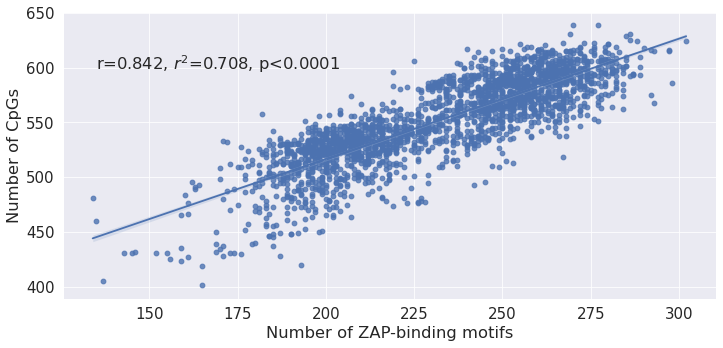

In [50]:
sns.set_context("paper", font_scale=1.7)

g = sns.regplot(
    data=df_plot,
    x='zap_motifs',
    y='cpg_count',

)
g.set(xlabel="Number of ZAP-binding motifs", ylabel="Number of CpGs")

r, p = pearsonr(df_plot['zap_motifs'], df_plot['cpg_count'])
ax = plt.gca()

if p < 0.0001:
    p_value_str = "p<0.0001"
else:
    p_value_str = f"p={p}"

ax.text(
    .05, .8, 
    f'r={r:.3f}, $r^{2}$={r**2:.3f}, {p_value_str}',
    transform=ax.transAxes
)
    
# plt.savefig("/content/drive/MyDrive/hcv_seq_analysis/plots/figure_02.png", dpi=300)

#### Figure 1

In [51]:
df_plot['hue'].value_counts()

Contemporary    1319
Historical       201
Name: hue, dtype: int64

In [52]:
len(df_plot.query('timeline >= 2001').query('timeline <= 2018'))

2483

Text(0.28, 0.33, 'F')

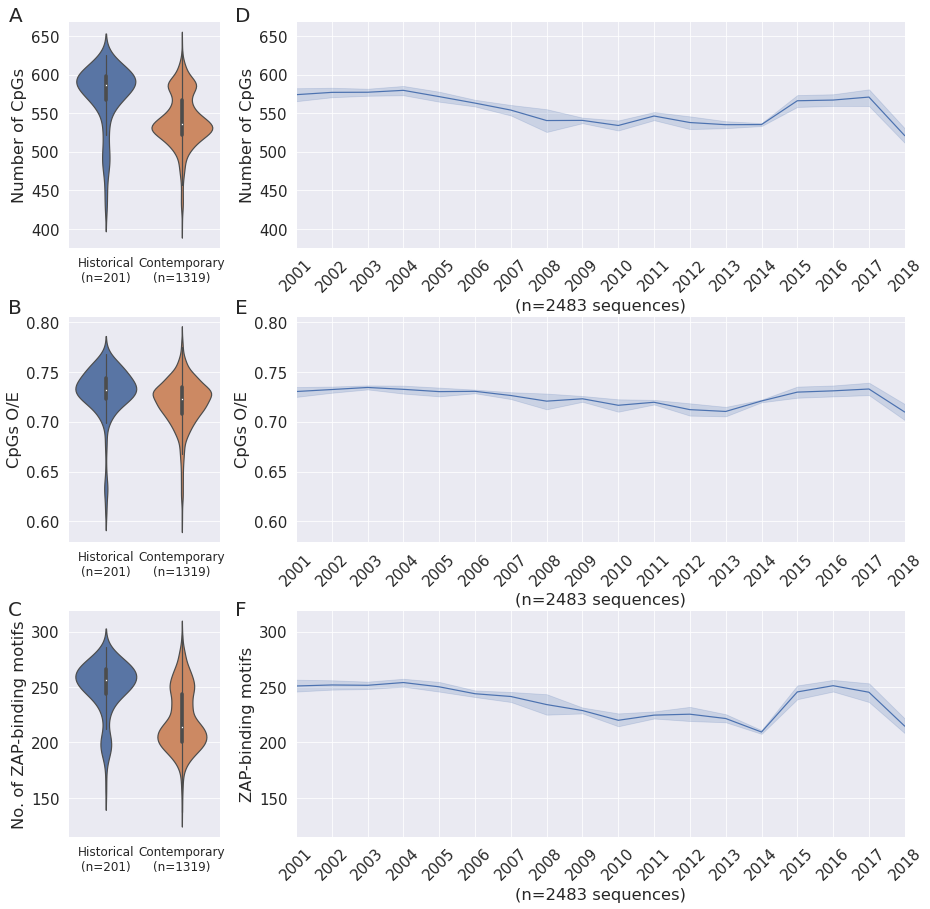

In [53]:
sns.set_context("paper", font_scale=1.7)
fig = plt.figure(figsize=(15, 15))
# grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.3)
grid = plt.GridSpec(3, 4, wspace=0.5, hspace=0.3)

v_c = fig.add_subplot(grid[2, 0])
v_a = fig.add_subplot(grid[0, 0], sharex=v_c)
v_b = fig.add_subplot(grid[1, 0], sharex=v_c)
l_f = fig.add_subplot(grid[2, 1:], sharey=v_c)
l_d = fig.add_subplot(grid[0, 1:], sharey=v_a, sharex=l_f)
l_e = fig.add_subplot(grid[1, 1:], sharey=v_b, sharex=l_f)
# y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
# x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# Number of CpGs Violinplot
g = sns.violinplot(
    x='hue',
    y='cpg_count',
    data=df_plot,
    kind='violin',
    ax=v_a
)
g.set_xticklabels(["Historical\n(n=201)", "Contemporary\n(n=1319)"], fontsize=12)
g.set(xlabel="", ylabel="Number of CpGs")
v_a.text(0.07, 0.88, "A", transform=fig.transFigure, size=20) # weight="bold"
# CpGs O/E Violinplot
g = sns.violinplot(
    x='hue',
    y='cpg_obye',
    data=df_plot,
    kind='violin',
    ax=v_b
)
g.set_xticklabels(["Historical\n(n=201)", "Contemporary\n(n=1319)"], fontsize=12)
g.set(xlabel="", ylabel="CpGs O/E")
v_b.text(0.07, 0.61, "B", transform=fig.transFigure, size=20)
# ZAP-binding motifs Violinplot
g = sns.violinplot(
    x='hue',
    y='zap_motifs',
    data=df_plot,
    kind='violin',
    ax=v_c
)
# g.fig.suptitle("p<0.0001")
g.set_xticklabels(["Historical\n(n=201)", "Contemporary\n(n=1319)"], fontsize=12)
g.set(xlabel="", ylabel="No. of ZAP-binding motifs")
v_c.text(0.07, 0.33, "C", transform=fig.transFigure, size=20)

# Number of CpGs Lineplot
g = sns.lineplot(
    data=df_plot.query('timeline >= 2001').query('timeline <= 2018'),
    x='timeline',
    y='cpg_count',
    ax=l_d
)

g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.xaxis.set_major_locator(mdates.YearLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
# for ax in g.axes.flat:
#     ax.xaxis.set_major_locator(mdates.YearLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
datemin = datetime.date(df_plot.query('timeline >= 2001').query('timeline <= 2018').timeline.min().year, 1, 1)
datemax = datetime.date(df_plot.query('timeline >= 2001').query('timeline <= 2018').timeline.max().year, 1, 1)
g.set(xlim=(datemin, datemax))
g.set(xlabel="(n=2483 sequences)", ylabel="Number of CpGs")
l_d.text(0.28, 0.88, "D", transform=fig.transFigure, size=20)

# CpGs O/E Lineplot
g = sns.lineplot(
    data=df_plot.query('timeline >= 2001').query('timeline <= 2018'),
    x='timeline',
    y='cpg_obye',
    ax=l_e
)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.xaxis.set_major_locator(mdates.YearLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
datemin = datetime.date(df_plot.query('timeline >= 2001').query('timeline <= 2018').timeline.min().year, 1, 1)
datemax = datetime.date(df_plot.query('timeline >= 2001').query('timeline <= 2018').timeline.max().year, 1, 1)
g.set(xlim=(datemin, datemax))
g.set(xlabel="(n=2483 sequences)", ylabel="CpGs O/E")
l_e.text(0.28, 0.61, "E", transform=fig.transFigure, size=20)

# ZAP-binding motifs Lineplot
g = sns.lineplot(
    data=df_plot.query('timeline >= 2001').query('timeline <= 2018'),
    x='timeline',
    y='zap_motifs',
    ax=l_f
)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.xaxis.set_major_locator(mdates.YearLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
datemin = datetime.date(df_plot.query('timeline >= 2001').query('timeline <= 2018').timeline.min().year, 1, 1)
datemax = datetime.date(df_plot.query('timeline >= 2001').query('timeline <= 2018').timeline.max().year, 1, 1)
g.set(xlim=(datemin, datemax))
g.set(xlabel="(n=2483 sequences)", ylabel="ZAP-binding motifs")
l_f.text(0.28, 0.33, "F", transform=fig.transFigure, size=20)
# plt.savefig("/content/drive/MyDrive/hcv_seq_analysis/plots/figure_01.png", dpi=300)

In [54]:
df_plot[df_plot.hue == 'Historical'].zap_motifs.median()

256.0

#### Supplementary Figure 1

In [55]:
df_plot1[df_plot1.hue != 'rest'].hue.value_counts()

Contemporary    315
Historical      165
Name: hue, dtype: int64

In [56]:
df_plot2[df_plot2.hue != 'rest'].hue.value_counts()

Contemporary    75
Historical      12
Name: hue, dtype: int64

In [57]:
df_plot1a[df_plot1a.hue != 'rest'].hue.value_counts()

Contemporary    128
Historical      110
Name: hue, dtype: int64

In [58]:
df_plot1b[df_plot1b.hue != 'rest'].hue.value_counts()

Contemporary    139
Historical       54
Name: hue, dtype: int64

In [59]:
df_plot['hue'].value_counts()

Contemporary    1319
Historical       201
Name: hue, dtype: int64

Text(0.71, 0.45, 'F')

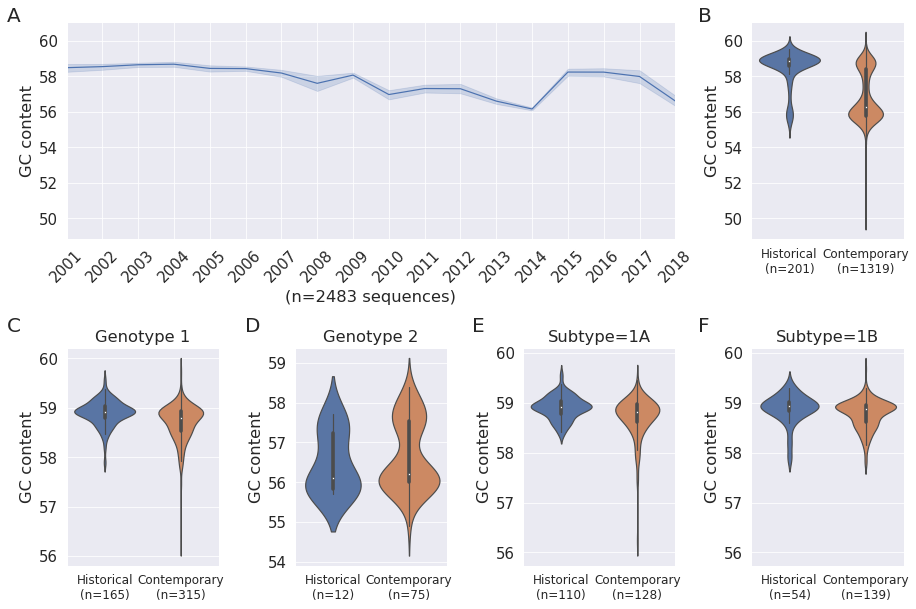

In [60]:
sns.set_context("paper", font_scale=1.7)
fig = plt.figure(figsize=(15, 10))
grid = plt.GridSpec(2, 4, wspace=0.5, hspace=0.5)


l_a = fig.add_subplot(grid[0, 0:3])
v_b = fig.add_subplot(grid[0, 3], sharey=l_a)
v_c = fig.add_subplot(grid[1, 0])
v_d = fig.add_subplot(grid[1, 1])
v_e = fig.add_subplot(grid[1, 2])
v_f = fig.add_subplot(grid[1, 3], sharey=v_e)


# Overall Lineplot
g = sns.lineplot(
    data=df_plot.query('timeline >= 2001').query('timeline <= 2018'),
    x='timeline',
    y='gc_content',
    ax=l_a
)

g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.xaxis.set_major_locator(mdates.YearLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
datemin = datetime.date(df_plot.query('timeline >= 2001').query('timeline <= 2018').timeline.min().year, 1, 1)
datemax = datetime.date(df_plot.query('timeline >= 2001').query('timeline <= 2018').timeline.max().year, 1, 1)
g.set(xlim=(datemin, datemax))
g.set(xlabel="(n=2483 sequences)", ylabel="GC content")
l_a.text(0.07, 0.88, "A", transform=fig.transFigure, size=20) # weight="bold"

# Overall Violinplot
g = sns.violinplot(
    x='hue',
    y='gc_content',
    data=df_plot,
    kind='violin',
    ax=v_b
)
g.set_xticklabels(["Historical\n(n=201)", "Contemporary\n(n=1319)"], fontsize=12)
g.set(xlabel="", ylabel="GC content")
v_b.text(0.71, 0.88, "B", transform=fig.transFigure, size=20)


# Genotype 1 Violinplot
g = sns.violinplot(
    x='hue',
    y='gc_content',
    data=df_plot1[df_plot1.hue != 'rest'],
    kind='violin',
    ax=v_c
)
g.set_xticklabels(["Historical\n(n=165)", "Contemporary\n(n=315)"], fontsize=12)
g.set(xlabel="", ylabel="GC content", title="Genotype 1")
v_c.text(0.07, 0.45, "C", transform=fig.transFigure, size=20)

# Genotype 2 Violinplot
g = sns.violinplot(
    x='hue',
    y='gc_content',
    data=df_plot2[df_plot2.hue != 'rest'],
    kind='violin',
    ax=v_d
)
g.set_xticklabels(["Historical\n(n=12)", "Contemporary\n(n=75)"], fontsize=12)
g.set(xlabel="", ylabel="GC content", title="Genotype 2")
v_d.text(0.29, 0.45, "D", transform=fig.transFigure, size=20)


# Subtypes 1A Violinplots
g = sns.violinplot(
    x='hue',
    y='gc_content',
    data=df_plot1a[df_plot1a.hue != 'rest'],
    kind='violin',
    ax=v_e
)
g.set_xticklabels(["Historical\n(n=110)", "Contemporary\n(n=128)"], fontsize=12)
g.set(xlabel="", ylabel="GC content", title="Subtype=1A")
v_e.text(0.5, 0.45, "E", transform=fig.transFigure, size=20)

# Subtypes 1B Violinplots
g = sns.violinplot(
    x='hue',
    y='gc_content',
    data=df_plot1b[df_plot1b.hue != 'rest'],
    kind='violin',
    ax=v_f
)
g.set_xticklabels(["Historical\n(n=54)", "Contemporary\n(n=139)"], fontsize=12)
g.set(xlabel="", ylabel="GC content", title="Subtype=1B")
v_f.text(0.71, 0.45, "F", transform=fig.transFigure, size=20)

# plt.savefig("/content/drive/MyDrive/hcv_seq_analysis/plots/supplementary_figure_01.png", dpi=300)

#### Supplementary Figure 2

Text(0.48, 0.325, 'F')

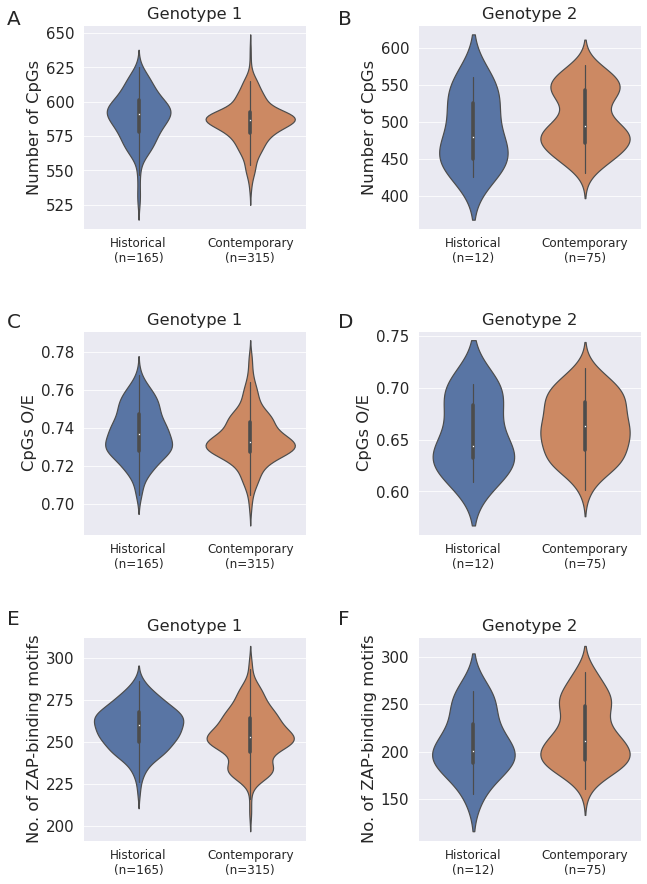

In [61]:
sns.set_context("paper", font_scale=1.7)
fig = plt.figure(figsize=(10, 15))
grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)

v_a = fig.add_subplot(grid[0, 0])
v_b = fig.add_subplot(grid[0, 1])
v_c = fig.add_subplot(grid[1, 0])
v_d = fig.add_subplot(grid[1, 1])
v_e = fig.add_subplot(grid[2, 0])
v_f = fig.add_subplot(grid[2, 1])


# Genotype 1- Number of CpGs
g = sns.violinplot(
    x='hue',
    y='cpg_count',
    data=df_plot1[df_plot1.hue != 'rest'],
    kind='violin',
    ax=v_a
)
g.set_xticklabels(["Historical\n(n=165)", "Contemporary\n(n=315)"], fontsize=12)
g.set(xlabel="", ylabel="Number of CpGs", title="Genotype 1")
v_a.text(0.02, 0.88, "A", transform=fig.transFigure, size=20) # weight="bold"

# Genotype 2- Number of CpGs
g = sns.violinplot(
    x='hue',
    y='cpg_count',
    data=df_plot2[df_plot2.hue != 'rest'],
    kind='violin',
    ax=v_b
)
g.set_xticklabels(["Historical\n(n=12)", "Contemporary\n(n=75)"], fontsize=12)
g.set(xlabel="", ylabel="Number of CpGs", title="Genotype 2")
v_b.text(0.48, 0.88, "B", transform=fig.transFigure, size=20)


# Genotype 1- CpGs O/E
g = sns.violinplot(
    x='hue',
    y='cpg_obye',
    data=df_plot1[df_plot1.hue != 'rest'],
    kind='violin',
    ax=v_c
)
g.set_xticklabels(["Historical\n(n=165)", "Contemporary\n(n=315)"], fontsize=12)
g.set(xlabel="", ylabel="CpGs O/E", title="Genotype 1")
v_c.text(0.02, 0.6, "C", transform=fig.transFigure, size=20)

# Genotype 2- CpGs O/E
g = sns.violinplot(
    x='hue',
    y='cpg_obye',
    data=df_plot2[df_plot2.hue != 'rest'],
    kind='violin',
    ax=v_d
)
g.set_xticklabels(["Historical\n(n=12)", "Contemporary\n(n=75)"], fontsize=12)
g.set(xlabel="", ylabel="CpGs O/E", title="Genotype 2")
v_d.text(0.48, 0.6, "D", transform=fig.transFigure, size=20)


# Genotype 1- Number of ZAP-binding motifs
g = sns.violinplot(
    x='hue',
    y='zap_motifs',
    data=df_plot1[df_plot1.hue != 'rest'],
    kind='violin',
    ax=v_e
)
g.set_xticklabels(["Historical\n(n=165)", "Contemporary\n(n=315)"], fontsize=12)
g.set(xlabel="", ylabel="No. of ZAP-binding motifs", title="Genotype 1")
v_e.text(0.02, 0.325, "E", transform=fig.transFigure, size=20)

# Genotype 2- Number of ZAP-binding motifs
g = sns.violinplot(
    x='hue',
    y='zap_motifs',
    data=df_plot2[df_plot2.hue != 'rest'],
    kind='violin',
    ax=v_f
)
g.set_xticklabels(["Historical\n(n=12)", "Contemporary\n(n=75)"], fontsize=12)
g.set(xlabel="", ylabel="No. of ZAP-binding motifs", title="Genotype 2")
v_f.text(0.48, 0.325, "F", transform=fig.transFigure, size=20)

# plt.savefig("/content/drive/MyDrive/hcv_seq_analysis/plots/supplementary_figure_02.png", dpi=300)

#### Supplementary Figure 3

Text(0.48, 0.325, 'F')

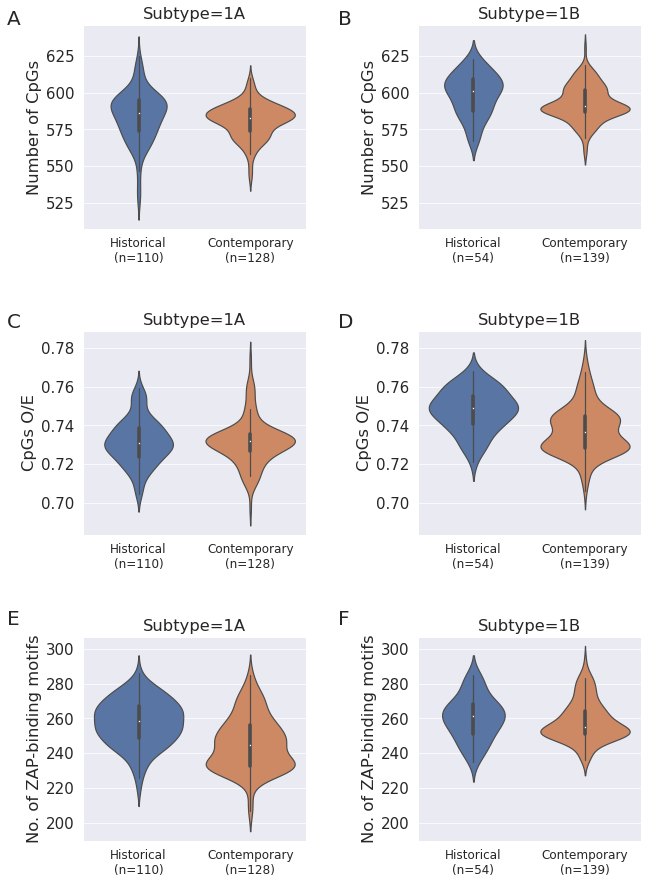

In [62]:
sns.set_context("paper", font_scale=1.7)
fig = plt.figure(figsize=(10, 15))
grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)

v_a = fig.add_subplot(grid[0, 0])
v_b = fig.add_subplot(grid[0, 1], sharey=v_a)
v_c = fig.add_subplot(grid[1, 0])
v_d = fig.add_subplot(grid[1, 1], sharey=v_c)
v_e = fig.add_subplot(grid[2, 0])
v_f = fig.add_subplot(grid[2, 1], sharey=v_e)


# Subtype 1A- Number of CpGs
g = sns.violinplot(
    x='hue',
    y='cpg_count',
    data=df_plot1a[df_plot1a.hue != 'rest'],
    kind='violin',
    ax=v_a
)
g.set_xticklabels(["Historical\n(n=110)", "Contemporary\n(n=128)"], fontsize=12)
g.set(xlabel="", ylabel="Number of CpGs", title="Subtype=1A")
v_a.text(0.02, 0.88, "A", transform=fig.transFigure, size=20) # weight="bold"

# Subtype 1B- Number of CpGs
g = sns.violinplot(
    x='hue',
    y='cpg_count',
    data=df_plot1b[df_plot1b.hue != 'rest'],
    kind='violin',
    ax=v_b
)
g.set_xticklabels(["Historical\n(n=54)", "Contemporary\n(n=139)"], fontsize=12)
g.set(xlabel="", ylabel="Number of CpGs", title="Subtype=1B")
v_b.text(0.48, 0.88, "B", transform=fig.transFigure, size=20)


# Subtype 1A- CpGs O/E
g = sns.violinplot(
    x='hue',
    y='cpg_obye',
    data=df_plot1a[df_plot1a.hue != 'rest'],
    kind='violin',
    ax=v_c
)
g.set_xticklabels(["Historical\n(n=110)", "Contemporary\n(n=128)"], fontsize=12)
g.set(xlabel="", ylabel="CpGs O/E", title="Subtype=1A")
v_c.text(0.02, 0.6, "C", transform=fig.transFigure, size=20)

# Subtype 1B- CpGs O/E
g = sns.violinplot(
    x='hue',
    y='cpg_obye',
    data=df_plot1b[df_plot1b.hue != 'rest'],
    kind='violin',
    ax=v_d
)
g.set_xticklabels(["Historical\n(n=54)", "Contemporary\n(n=139)"], fontsize=12)
g.set(xlabel="", ylabel="CpGs O/E", title="Subtype=1B")
v_d.text(0.48, 0.6, "D", transform=fig.transFigure, size=20)


# Subtype 1A- Number of ZAP-binding motifs
g = sns.violinplot(
    x='hue',
    y='zap_motifs',
    data=df_plot1a[df_plot1a.hue != 'rest'],
    kind='violin',
    ax=v_e
)
g.set_xticklabels(["Historical\n(n=110)", "Contemporary\n(n=128)"], fontsize=12)
g.set(xlabel="", ylabel="No. of ZAP-binding motifs", title="Subtype=1A")
v_e.text(0.02, 0.325, "E", transform=fig.transFigure, size=20)

# Subtype 1B- Number of ZAP-binding motifs
g = sns.violinplot(
    x='hue',
    y='zap_motifs',
    data=df_plot1b[df_plot1b.hue != 'rest'],
    kind='violin',
    ax=v_f
)
g.set_xticklabels(["Historical\n(n=54)", "Contemporary\n(n=139)"], fontsize=12)
g.set(xlabel="", ylabel="No. of ZAP-binding motifs", title="Subtype=1B")
v_f.text(0.48, 0.325, "F", transform=fig.transFigure, size=20)

# plt.savefig("/content/drive/MyDrive/hcv_seq_analysis/plots/supplementary_figure_03.png", dpi=300)

# MSA

## Preparing input file for MAFFT

In [63]:
idlist_filtered = []

for id in df['accession_id']:
    idlist_filtered.append(id.split('.')[0])

In [64]:
handle_for_msa = Entrez.efetch(db='nucleotide', id=['NC_004102.1', *idlist_filtered], rettype='fasta')
records_for_msa = SeqIO.parse(handle_for_msa, 'fasta')
records_for_msa = [i for i in records_for_msa]

SeqIO.write(records_for_msa, 'fasta_ref_and_2616_output.fasta', 'fasta')

2617

## MSA generation

The resulting alignment of 2616 sequences is created using mafft v7.490 (2021/Oct/30) https://doi.org/10.1093/molbev/mst010 in a single step:

Each sequence is individually aligned to the H77 reference genome (Accession ID: NC_004102.1). The alignments are created with the command:

	mafft --thread -1 input.fasta > output.fasta


Default parameters:
- fft, Use FFT approximation (FFT-NS-2) in group-to-group alignment
- 6merpair, distance is calculated based on the number of shared 6mers
- retree 2, guide tree is built 2 times in the progressive stage
- memsave(Using the Myers-Miller 1988 algorithm) is automatically turned on when the alignment length exceeds 10k (aa/nt)
- op 1.53, gap opening penalty at group-to-group alignment
- ep .123, offset value, which works like gap extension penalty, for group-to-group alignment
- bl 62, BLOSUM number matrix (Henikoff and Henikoff 1992) is used
- inputorder, output order same as input order

## Formatting Output file from MAFFT

In [65]:
alignment = AlignIO.read(
    "output_msa.fasta", format="fasta"
)

print(alignment)

Alignment with 2617 rows and 13428 columns
--------------------------------------------...--- NC_004102.1
--------------------------------------------...--- AB429050.1
--------------------------------------------...--- AB622121.1
--------------------------------------------...--- AB677527.1
--------------------------------------------...--- AB677528.1
--------------------------------------------...--- AB677529.1
--------------------------------------------...--- AB677530.1
--------------------------------------------...--- AB677531.1
--------------------------------------------...--- AB677532.1
--------------------------------------------...--- AB677533.1
--------------------------------------------...--- AB690460.1
--------------------------------------------...--- AB690461.1
--------------------------------------------...--- AB792683.1
--------------------------------------------...act AB795432.3
--------------------------------------------...--- AB828699.1
--------------------------

In [66]:
# Preparing input file for generate_mapping.py
with open("prepost_hcv_ref_seq.fasta", "w") as file:
    for record in records_for_msa:
        if record.id == "NC_004102.1":
            file.writelines(f"{record.description}\n")
            file.write(f"{str(record.seq)}\n")
    for aln in alignment:
        if aln.id == "NC_004102.1":
            file.write(f"{aln.description}\n")
            file.write(f"{str(aln.seq)}")

In [67]:
!head prepost_hcv_ref_seq.fasta

NC_004102.1 Hepatitis C virus genotype 1, complete genome
GCCAGCCCCCTGATGGGGGCGACACTCCACCATGAATCACTCCCCTGTGAGGAACTACTGTCTTCACGCAGAAAGCGTCTAGCCATGGCGTTAGTATGAGTGTCGTGCAGCCTCCAGGACCCCCCCTCCCGGGAGAGCCATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACGACCGGGTCCTTTCTTGGATAAACCCGCTCAATGCCTGGAGATTTGGGCGTGCCCCCGCAAGACTGCTAGCCGAGTAGTGTTGGGTCGCGAAAGGCCTTGTGGTACTGCCTGATAGGGTGCTTGCGAGTGCCCCGGGAGGTCTCGTAGACCGTGCACCATGAGCACGAATCCTAAACCTCAAAGAAAAACCAAACGTAACACCAACCGTCGCCCACAGGACGTCAAGTTCCCGGGTGGCGGTCAGATCGTTGGTGGAGTTTACTTGTTGCCGCGCAGGGGCCCTAGATTGGGTGTGCGCGCGACGAGGAAGACTTCCGAGCGGTCGCAACCTCGAGGTAGACGTCAGCCTATCCCCAAGGCACGTCGGCCCGAGGGCAGGACCTGGGCTCAGCCCGGGTACCCTTGGCCCCTCTATGGCAATGAGGGTTGCGGGTGGGCGGGATGGCTCCTGTCTCCCCGTGGCTCTCGGCCTAGCTGGGGCCCCACAGACCCCCGGCGTAGGTCGCGCAATTTGGGTAAGGTCATCGATACCCTTACGTGCGGCTTCGCCGACCTCATGGGGTACATACCGCTCGTCGGCGCCCCTCTTGGAGGCGCTGCCAGGGCCCTGGCGCATGGCGTCCGGGTTCTGGAAGACGGCGTGAACTATGCAACAGGGAACCTTCCTGGTTGCTCTTTCTCTATCTTCCTTCTGGCCCTGCTCTCTTGCCTGACTGTGCCCGCTTCAGCCTACCAAGTGCGCAATTCCTCGGGGCTTT

## Mapping (pre- and post-alignment MSA for ref seq)

In [68]:
seqArray = []

with open("prepost_hcv_ref_seq.fasta") as infile:
    for line1, line2 in itertools.zip_longest(*[infile] * 2):
        seqArray.append(line2.replace("\n", "").upper())

seqArray = [i for i in seqArray[-1]] # list(seqArray[-1])

df_mapping = pd.DataFrame(seqArray, columns=["aligned_seq"])
df_mapping["aligned_number"] = df_mapping.apply(lambda x: x.index + 1)

for row in df_mapping.itertuples():
    if row.aligned_seq == "-":
        if row.Index == 0:
            count = [0]
        else:
            count.append(count[-1])
    else:
        if row.Index == 0:
            count = [1]
        else:
            count.append(count[-1] + 1)

df_mapping["pre_aligned_number"] = count
df_mapping["pre_aligned_number"] = df_mapping.apply(
    lambda x: "Ins: "
    + str(x["pre_aligned_number"])
    + ", pa: "
    + str(x["aligned_number"])
    if x["aligned_seq"] == "-"
    else x["pre_aligned_number"],
    axis=1,
)

df_mapping.to_excel("mapping.xlsx", index=True)

In [69]:
df_mapping.sample(n=10)

,aligned_seq,aligned_number,pre_aligned_number
6511,C,6512,4612
10532,C,10533,7879
2490,A,2491,1305
7202,C,7203,5267
13285,G,13286,9618
5988,G,5989,4092
10994,C,10995,8305
7206,T,7207,5271
3907,G,3908,2318
11546,G,11547,8734


# Ref seq (NT stats, df prep, and merging df with the master df with ref seq entry at the top)

[Reference seqs for each Genotype](https://www.ncbi.nlm.nih.gov/genomes/GenomesGroup.cgi?taxid=11102).

LANL's HCV database mentioned [H77(NC_004102.1)](https://www.ncbi.nlm.nih.gov/nuccore/NC_004102.1) as reference sequence, hence we're using that.

In [70]:
gb_handle_for_msa = Entrez.efetch(db='nucleotide', id=['NC_004102.1', *idlist_filtered], rettype='gb')
gb_records_for_msa = SeqIO.parse(gb_handle_for_msa, 'gb')
gb_records_for_msa = [i for i in gb_records_for_msa]

datalist = []

for gb_record in gb_records_for_msa:
    gb_feature = gb_record.features[index_genbank_features(gb_record, 'source')]
    # print(gb_record.annotations)
    datalist.append(
        [
            gb_record.id,                                               # accession id
            str(gb_record.seq),                                         # seq
            len(gb_record.seq),                                         # seq len                
            gb_feature.qualifiers.get('collection_date', ['None'])[0],  # collection date
            gb_feature.qualifiers.get('strain', ['None'])[0],           # strain
            gb_feature.qualifiers.get('isolate', ['None'])[0],          # isolate
            gb_feature.qualifiers.get('country', ['None'])[0],          # country
            gb_feature.qualifiers.get('note', ['None'])[0],             # genotype/subtype
            gb_feature.qualifiers.get('organism', ['None'])[0],         # organism
            gb_record.description                                       # header
        ]
    )


DF = pd.DataFrame(
    datalist,
    columns=[
        'accession_id',
        'seq',
        'seq_len',
        'collection_date',
        'strain',
        'isolate',
        'country',
        'genotype',
        'organism',
        'header',
    ]
)

DF['cpg_count'] = 0
DF['cpg_per'] = 0.0
DF['cpg_obye'] = 0.0
DF['gc_content'] = 0.0


for row in DF.itertuples():

    temp_seq_cpg_count = Seq(row.seq).count('CG')
    temp_seq_c_count = Seq(row.seq).count('C')
    temp_seq_g_count = Seq(row.seq).count('G')

    DF.at[row.Index, 'cpg_count'] = temp_seq_cpg_count
    DF.at[row.Index, 'cpg_per'] = 100 * (temp_seq_cpg_count / row.seq_len)
    DF.at[row.Index, 'cpg_obye'] = (temp_seq_cpg_count * row.seq_len) / (temp_seq_c_count * temp_seq_g_count)
    DF.at[row.Index, 'gc_content'] = GC(Seq(row.seq))

DF.replace(to_replace='None', value=np.nan, inplace=True)
DF['year'] = pd.to_datetime(DF.collection_date).dt.strftime('%Y')

/usr/local/lib/python3.8/dist-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


In [71]:
DF.head()

,accession_id,seq,seq_len,collection_date,strain,isolate,country,genotype,organism,header,cpg_count,cpg_per,cpg_obye,gc_content,year
0,NC_004102.1,GCCAGCCCCCTGATGGGGGCGACACTCCACCATGAATCACTCCCCT...,9646,NaN,NaN,H77,NaN,assembled from cDNA library representing a pop...,Hepatitis C virus genotype 1,"Hepatitis C virus genotype 1, complete genome",597,6.189094,0.730745,58.231391,NaN
1,AB429050.1,GCCAGCCCCCGATTGGGGGCGACACTCCACCATAGATCACTCCCCT...,9374,18-Mar-1991,NaN,AH1,Japan: Niigata,subtype 1b,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple...",610,6.507361,0.753248,58.800939,1991
2,AB622121.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9452,05-Aug-2010,NaN,HC10-0804,Japan:Ibaraki,A natural inter-genotypic (2b/1b) recombinant,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple...",521,5.512061,0.679179,57.003809,2010
3,AB677527.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9471,16-Nov-1993,NaN,HCV-B5808,"Japan: Saitama, Tokorozawa",HCV-B5808 and HCV-M4430 were isolated from sam...,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple...",551,5.817759,0.706052,57.427938,1993
4,AB677528.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9471,12-May-2010,NaN,HCV-M4430,"Japan:Saitama, Tokorozawa",HCV-B5808 and HCV-M4430 were isolated from sam...,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple...",544,5.743850,0.700410,57.301235,2010


In [72]:
# DF.to_csv('df03_2617.csv', index=False)

# ZAP-binding motif analysis

## Calculations-I

In [73]:
def zap_n_motif_constructor(m):
    """Constructs the pattern for ZAP-binding motif given n
    Input: m is the m in C(n_{m})G(n)CG, where m = 4/5/6/7/8
    Returns the raw string for the desired ZAP-binding motif 
    """
    zap_motif = r"[cC]-*"
    for i in range(m):
        zap_motif = zap_motif + r"[aAtTcCgG]-*"
    return zap_motif + r"[gG]-*[aAtTcCgG]-*[cC]-*[gG]"

In [74]:
DF.head()

,accession_id,seq,seq_len,collection_date,strain,isolate,country,genotype,organism,header,cpg_count,cpg_per,cpg_obye,gc_content,year
0,NC_004102.1,GCCAGCCCCCTGATGGGGGCGACACTCCACCATGAATCACTCCCCT...,9646,NaN,NaN,H77,NaN,assembled from cDNA library representing a pop...,Hepatitis C virus genotype 1,"Hepatitis C virus genotype 1, complete genome",597,6.189094,0.730745,58.231391,NaN
1,AB429050.1,GCCAGCCCCCGATTGGGGGCGACACTCCACCATAGATCACTCCCCT...,9374,18-Mar-1991,NaN,AH1,Japan: Niigata,subtype 1b,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple...",610,6.507361,0.753248,58.800939,1991
2,AB622121.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9452,05-Aug-2010,NaN,HC10-0804,Japan:Ibaraki,A natural inter-genotypic (2b/1b) recombinant,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple...",521,5.512061,0.679179,57.003809,2010
3,AB677527.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9471,16-Nov-1993,NaN,HCV-B5808,"Japan: Saitama, Tokorozawa",HCV-B5808 and HCV-M4430 were isolated from sam...,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple...",551,5.817759,0.706052,57.427938,1993
4,AB677528.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9471,12-May-2010,NaN,HCV-M4430,"Japan:Saitama, Tokorozawa",HCV-B5808 and HCV-M4430 were isolated from sam...,Hepacivirus C,"Hepatitis C virus gene for polyprotein, comple...",544,5.743850,0.700410,57.301235,2010


In [75]:
# df_zap = DF[['accession_id', 'seq', 'seq_len', 'year', 'cpg_count', 'cpg_per', 'cpg_obye', 'gc_content']]
df_zap = DF[['accession_id', 'seq', 'seq_len', 'year']]

In [76]:
# df_zap = pd.DataFrame(df.iloc[0]).rename(columns={0: "seq"}).iloc[2:13]
df_zap = df_zap.assign(
    zap_4_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(4)}"),
    zap_5_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(5)}"),
    zap_6_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(6)}"),
    zap_7_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(7)}"),
    zap_8_motif_count=lambda x: x.seq.str.count(rf"{zap_n_motif_constructor(8)}"),
)


In [77]:
df_zap['zap_motifs'] = df_zap['zap_4_motif_count'] + df_zap['zap_5_motif_count'] + df_zap['zap_6_motif_count'] + df_zap['zap_7_motif_count'] + df_zap['zap_8_motif_count']

df_zap

,accession_id,seq,seq_len,year,zap_4_motif_count,zap_5_motif_count,zap_6_motif_count,zap_7_motif_count,zap_8_motif_count,zap_motifs
0,NC_004102.1,GCCAGCCCCCTGATGGGGGCGACACTCCACCATGAATCACTCCCCT...,9646,NaN,39,51,63,56,49,258
1,AB429050.1,GCCAGCCCCCGATTGGGGGCGACACTCCACCATAGATCACTCCCCT...,9374,1991,44,63,65,50,51,273
2,AB622121.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9452,2010,30,45,54,29,41,199
3,AB677527.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9471,1993,34,57,50,39,45,225
4,AB677528.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9471,2010,34,54,49,36,46,219
...,...,...,...,...,...,...,...,...,...,...
2612,OM896997.1,TTCACGCGGAAAGCGCCTAGCCATGGCGTTAGTACGAGTGTCGTGC...,9345,2011,43,38,43,44,44,212
2613,OM896998.1,TTCACGCGGAAAGCGCCTAGCCATGGCGTTAGTACGAGTGTCGTGC...,9345,2011,44,39,42,42,41,208
2614,OM896999.1,TTCACGCGGAAAGCGCCTAGCCATGGCGTTAGTACGAGTGTCGTGC...,9345,2011,38,40,44,41,44,207
2615,OM897000.1,TTCACGCGGAAAGCGCCTAGCCATGGCGTTAGTACGAGTGTCGTGC...,9345,2011,44,39,47,44,46,220


In [78]:
# df_zap.to_csv('df_zap_counts.csv', index=False)

In [79]:
df_plot_zap = df_zap[pd.notnull(df_zap['year'])][
    [
        'year', 
        'zap_motifs', 
        'zap_4_motif_count', 
        'zap_5_motif_count', 
        'zap_6_motif_count', 
        'zap_7_motif_count', 
        'zap_8_motif_count'
    ]
].sort_values(by='year').reset_index(drop=True)

df_plot_zap['timeline'] = pd.to_datetime(df_plot_zap['year'])

In [80]:
df_plot_zap

,year,zap_motifs,zap_4_motif_count,zap_5_motif_count,zap_6_motif_count,zap_7_motif_count,zap_8_motif_count,timeline
0,1977,252,37,49,62,53,51,1977-01-01
1,1977,252,37,50,63,53,49,1977-01-01
2,1977,252,38,49,63,52,50,1977-01-01
3,1977,254,38,50,63,53,50,1977-01-01
4,1977,258,36,52,66,54,50,1977-01-01
...,...,...,...,...,...,...,...,...
2611,2019,182,35,40,41,32,34,2019-01-01
2612,2019,210,47,36,44,41,42,2019-01-01
2613,2020,264,41,66,66,44,47,2020-01-01
2614,2021,269,35,71,68,47,48,2021-01-01


## Calculations-II

In [81]:
def find_motif(motif, genome):
    """Locates all occurences of the input motif in the
	input genome and returns a list of their start positions
	within that genome
	"""
    return [m.start() for m in re.finditer(rf"(?={motif})", genome)]

In [82]:
def process(info, genome, motif, datafile):
    """Uses find_motif() and appends a list of three entries to the datafile:
	1. the sequence's (i.e, input genome's)
	header,
	2. number of input motifs found within that input genome, and
	3. the matched motifs themselves

	Input:
	- datafile is where results will be stored,
	- genome is the sequence where motifs will be searched,
	- info is header of the sequence, and
	- motif is the pattern which should be matched in the genome

	Acceptable datatypes:
	- datafile should be a list/tuple,
	- genome should be a string,
	- info should be a string, and
	- motif should be a raw string.
	"""
    genome = genome.replace("\n", "")
    matches = find_motif(motif, genome)
    datafile.append([info, len(matches), matches])

In [83]:
def convert_to_int(loc):
    """Converts the type of the locations to int"""
    return list(map(int, loc))

In [84]:
with open('msa_properly_formatted.fasta', 'w') as f:
    for aln in alignment:
        f.write(f'>{aln.description}\n')
        f.write(f'{aln.seq}\n')

In [85]:
def motif_analyzer(motif, outfile_name):
    """Finds the locations of the motif within the full MSA file. It
	then maps it to the reference genome (mapping was done with the
	HCV reference sequence- H77). It also gives us the frequency
	and percentage of the ZAP-binding motifs and CpG sites at the locations
	where the motifs were found within the MSA file.

	Input:
	- motif is the pattern which should be matched in the genome. It should
		be a raw string
	- outfile_name is the name of the output file. It should have an
		.csv extension

	Output:
	- Saves a .csv file with the name outfile_name in the csv_files directory
	"""
    print(f'Analysis for "{motif}" motif begins...')
    data = []

    with open("msa_properly_formatted.fasta") as infile:
        for line1, line2 in tqdm(itertools.zip_longest(*[infile] * 2)):
            if line1 and line2 and line1.startswith(">"):
                process(info=line1[1:], genome=line2, motif=motif, datafile=data)

    data = pd.DataFrame(data, columns=["info", "number", "identified_motif_locations"])
    data["info"] = data["info"].replace(r"\n", "", regex=True)
    data["accession_ids"] = data["info"].str.split().str[0]

    count = Counter()
    data.apply(
        lambda x: count.update(convert_to_int(x["identified_motif_locations"])), axis=1
    )
    count = pd.DataFrame.from_dict(count, orient="index", columns=["frequency"])
    count["percentage"] = (count["frequency"] * 100) / len(data)

    mapper = pd.read_excel("mapping.xlsx")
    mapper = mapper.set_index(["Unnamed: 0"])
    count["mapping"] = mapper.loc[count.index]["pre_aligned_number"]

    count.to_csv(f"{outfile_name}", index_label="python_based_indices")

In [86]:
motif_analyzer(motif=r"[cC]-*[gG]", outfile_name="counter_file_cpg.csv")
motif_analyzer(
    motif=zap_n_motif_constructor(4), outfile_name="counter_file_zap_4_motif.csv"
)
motif_analyzer(
    motif=zap_n_motif_constructor(5), outfile_name="counter_file_zap_5_motif.csv"
)
motif_analyzer(
    motif=zap_n_motif_constructor(6), outfile_name="counter_file_zap_6_motif.csv"
)
motif_analyzer(
    motif=zap_n_motif_constructor(7), outfile_name="counter_file_zap_7_motif.csv"
)
motif_analyzer(
    motif=zap_n_motif_constructor(8), outfile_name="counter_file_zap_8_motif.csv"
)

Analysis for "[cC]-*[gG]" motif begins...


2617it [00:01, 1569.37it/s]


Analysis for "[cC]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[gG]-*[aAtTcCgG]-*[cC]-*[gG]" motif begins...


2617it [00:02, 1075.55it/s]


Analysis for "[cC]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[gG]-*[aAtTcCgG]-*[cC]-*[gG]" motif begins...


2617it [00:02, 951.02it/s]


Analysis for "[cC]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[gG]-*[aAtTcCgG]-*[cC]-*[gG]" motif begins...


2617it [00:02, 894.17it/s]


Analysis for "[cC]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[gG]-*[aAtTcCgG]-*[cC]-*[gG]" motif begins...


2617it [00:03, 855.43it/s]


Analysis for "[cC]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[aAtTcCgG]-*[gG]-*[aAtTcCgG]-*[cC]-*[gG]" motif begins...


2617it [00:03, 799.62it/s]


In [87]:
df_zap

,accession_id,seq,seq_len,year,zap_4_motif_count,zap_5_motif_count,zap_6_motif_count,zap_7_motif_count,zap_8_motif_count,zap_motifs
0,NC_004102.1,GCCAGCCCCCTGATGGGGGCGACACTCCACCATGAATCACTCCCCT...,9646,NaN,39,51,63,56,49,258
1,AB429050.1,GCCAGCCCCCGATTGGGGGCGACACTCCACCATAGATCACTCCCCT...,9374,1991,44,63,65,50,51,273
2,AB622121.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9452,2010,30,45,54,29,41,199
3,AB677527.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9471,1993,34,57,50,39,45,225
4,AB677528.1,GCCCGCCCCCTGATGGGGGCGACACTCCGCCATGAATCACTCCCCT...,9471,2010,34,54,49,36,46,219
...,...,...,...,...,...,...,...,...,...,...
2612,OM896997.1,TTCACGCGGAAAGCGCCTAGCCATGGCGTTAGTACGAGTGTCGTGC...,9345,2011,43,38,43,44,44,212
2613,OM896998.1,TTCACGCGGAAAGCGCCTAGCCATGGCGTTAGTACGAGTGTCGTGC...,9345,2011,44,39,42,42,41,208
2614,OM896999.1,TTCACGCGGAAAGCGCCTAGCCATGGCGTTAGTACGAGTGTCGTGC...,9345,2011,38,40,44,41,44,207
2615,OM897000.1,TTCACGCGGAAAGCGCCTAGCCATGGCGTTAGTACGAGTGTCGTGC...,9345,2011,44,39,47,44,46,220


In [88]:
df_zap4 = pd.read_csv('counter_file_zap_4_motif.csv')\
            .drop(columns=['python_based_indices'])\
            .rename(columns={'mapping': 'zap_binding_motif_position'})

df_zap5 = pd.read_csv('counter_file_zap_5_motif.csv')\
            .drop(columns=['python_based_indices'])\
            .rename(columns={'mapping': 'zap_binding_motif_position'})

df_zap6 = pd.read_csv('counter_file_zap_6_motif.csv')\
            .drop(columns=['python_based_indices'])\
            .rename(columns={'mapping': 'zap_binding_motif_position'})

df_zap7 = pd.read_csv('counter_file_zap_7_motif.csv')\
            .drop(columns=['python_based_indices'])\
            .rename(columns={'mapping': 'zap_binding_motif_position'})

df_zap8 = pd.read_csv('counter_file_zap_8_motif.csv')\
            .drop(columns=['python_based_indices'])\
            .rename(columns={'mapping': 'zap_binding_motif_position'})


df_zap4.name = 'ZAP-binding motif (n=4)'
df_zap5.name = 'ZAP-binding motif (n=5)'
df_zap6.name = 'ZAP-binding motif (n=6)'
df_zap7.name = 'ZAP-binding motif (n=7)'
df_zap8.name = 'ZAP-binding motif (n=8)'

print(
    f'- Length of {df_zap4.name} dataframe: {len(df_zap4)}\n'
    f'- Length of {df_zap5.name} dataframe: {len(df_zap5)}\n'
    f'- Length of {df_zap6.name} dataframe: {len(df_zap6)}\n'
    f'- Length of {df_zap7.name} dataframe: {len(df_zap7)}\n'
    f'- Length of {df_zap8.name} dataframe: {len(df_zap8)}'
)

- Length of ZAP-binding motif (n=4) dataframe: 1077
- Length of ZAP-binding motif (n=5) dataframe: 1333
- Length of ZAP-binding motif (n=6) dataframe: 1345
- Length of ZAP-binding motif (n=7) dataframe: 1051
- Length of ZAP-binding motif (n=8) dataframe: 1370


In [89]:
df_zap4.query('percentage >= 75', inplace=True)
df_zap5.query('percentage >= 75', inplace=True)
df_zap6.query('percentage >= 75', inplace=True)
df_zap7.query('percentage >= 75', inplace=True)
df_zap8.query('percentage >= 75', inplace=True)


print(
    f'After filtration: \n'
    f'- Length of {df_zap4.name} dataframe: {len(df_zap4)}\n'
    f'- Length of {df_zap5.name} dataframe: {len(df_zap5)}\n'
    f'- Length of {df_zap6.name} dataframe: {len(df_zap6)}\n'
    f'- Length of {df_zap7.name} dataframe: {len(df_zap7)}\n'
    f'- Length of {df_zap8.name} dataframe: {len(df_zap8)}'
)

After filtration: 
- Length of ZAP-binding motif (n=4) dataframe: 7
- Length of ZAP-binding motif (n=5) dataframe: 10
- Length of ZAP-binding motif (n=6) dataframe: 5
- Length of ZAP-binding motif (n=7) dataframe: 6
- Length of ZAP-binding motif (n=8) dataframe: 8


In [90]:
df_zap4['gap'] = 4
df_zap5['gap'] = 5
df_zap6['gap'] = 6
df_zap7['gap'] = 7
df_zap8['gap'] = 8

total_seqs_analyzed = 2616

df_zap4['Number of sequences where ZAP-binding motif is lost'] = total_seqs_analyzed - df_zap4['frequency']
df_zap5['Number of sequences where ZAP-binding motif is lost'] = total_seqs_analyzed - df_zap5['frequency']
df_zap6['Number of sequences where ZAP-binding motif is lost'] = total_seqs_analyzed - df_zap6['frequency']
df_zap7['Number of sequences where ZAP-binding motif is lost'] = total_seqs_analyzed - df_zap7['frequency']
df_zap8['Number of sequences where ZAP-binding motif is lost'] = total_seqs_analyzed - df_zap8['frequency']

In [91]:
df_zap4

,frequency,percentage,zap_binding_motif_position,gap,Number of sequences where ZAP-binding motif is lost
0,2163,82.651891,386,4,453
1,2415,92.281238,397,4,201
4,2356,90.026748,674,4,260
6,2116,80.855942,754,4,500
7,2130,81.390906,796,4,486
33,2105,80.435613,7915,4,511
35,2257,86.243791,8432,4,359


In [92]:
ref_seq = str(gb_records_for_msa[0].seq)

In [93]:
def add_three_cols(DF, GAP):
    """Adds three columns to the input dataframe(DF):
    1. Extracts ZAP-binding motifs using the reference sequence, 
    ZAP-binding position from DF, and GAP, i.e. m in C(n_{m})G(n)CG, 
    2. Calculates the position of terminal CpG within ZAP-binding motif, 
    3. Counts CpGs present within ZAP-binding motifs
    """
    DF['zap_binding_motif_position'] = DF.zap_binding_motif_position.apply(lambda x: int(x))
    DF['zap_binding_motif'] = DF.zap_binding_motif_position.apply(
        lambda x: f'{ref_seq[x-1]}({ref_seq[x:x+GAP]}){ref_seq[x+GAP]}({ref_seq[x+GAP+1]}){ref_seq[x+GAP+2:x+GAP+4]}'
    )
    DF['terminal_cpg_position'] = DF['zap_binding_motif_position'] + GAP + 3
    DF['cpgs_in_the_zap_binding_motif'] = DF.zap_binding_motif\
                                            .str.replace(r'[\(\)]', '', regex=True)\
                                            .str.count('CG')
    

add_three_cols(df_zap4, GAP=4)
add_three_cols(df_zap5, GAP=5)
add_three_cols(df_zap6, GAP=6)
add_three_cols(df_zap7, GAP=7)
add_three_cols(df_zap8, GAP=8)

In [94]:
df_zap4

,frequency,percentage,zap_binding_motif_position,gap,Number of sequences where ZAP-binding motif is lost,zap_binding_motif,terminal_cpg_position,cpgs_in_the_zap_binding_motif
0,2163,82.651891,386,4,453,C(AACC)G(T)CG,393,2
1,2415,92.281238,397,4,201,C(ACAG)G(A)CG,404,1
4,2356,90.026748,674,4,260,C(CCCC)G(G)CG,681,2
6,2116,80.855942,754,4,500,C(GCTC)G(T)CG,761,3
7,2130,81.390906,796,4,486,C(GCAT)G(G)CG,803,2
33,2105,80.435613,7915,4,511,C(AAAA)G(A)CG,7922,1
35,2257,86.243791,8432,4,359,C(AGGT)G(C)CG,8439,1


In [95]:
df_zap4['motif'] = 'C($n_{4}$)G($n$)CG'
df_zap5['motif'] = 'C($n_{5}$)G($n$)CG'
df_zap6['motif'] = 'C($n_{6}$)G($n$)CG'
df_zap7['motif'] = 'C($n_{7}$)G($n$)CG'
df_zap8['motif'] = 'C($n_{8}$)G($n$)CG'

In [96]:
pd.concat([df_zap4, df_zap5, df_zap6, df_zap7, df_zap8]).reset_index(drop=True)

,frequency,percentage,zap_binding_motif_position,gap,Number of sequences where ZAP-binding motif is lost,zap_binding_motif,terminal_cpg_position,cpgs_in_the_zap_binding_motif,motif
0,2163,82.651891,386,4,453,C(AACC)G(T)CG,393,2,C($n_{4}$)G($n$)CG
1,2415,92.281238,397,4,201,C(ACAG)G(A)CG,404,1,C($n_{4}$)G($n$)CG
2,2356,90.026748,674,4,260,C(CCCC)G(G)CG,681,2,C($n_{4}$)G($n$)CG
3,2116,80.855942,754,4,500,C(GCTC)G(T)CG,761,3,C($n_{4}$)G($n$)CG
4,2130,81.390906,796,4,486,C(GCAT)G(G)CG,803,2,C($n_{4}$)G($n$)CG
5,2105,80.435613,7915,4,511,C(AAAA)G(A)CG,7922,1,C($n_{4}$)G($n$)CG
6,2257,86.243791,8432,4,359,C(AGGT)G(C)CG,8439,1,C($n_{4}$)G($n$)CG
7,2386,91.173099,385,5,230,C(CAACC)G(T)CG,393,2,C($n_{5}$)G($n$)CG
8,2414,92.243026,396,5,202,C(CACAG)G(A)CG,404,1,C($n_{5}$)G($n$)CG
9,2447,93.504012,446,5,169,C(TTGTT)G(C)CG,454,1,C($n_{5}$)G($n$)CG


In [97]:
with Entrez.efetch(
    db="nucleotide", rettype="gb", retmode="text", id="NC_004102.1"
) as ref_seq_handle:
    ref_seq_record = SeqIO.read(ref_seq_handle, "gb")

print(ref_seq_record)

ID: NC_004102.1
Name: NC_004102
Description: Hepatitis C virus genotype 1, complete genome
Database cross-references: BioProject:PRJNA485481
Number of features: 16
/molecule_type=ss-RNA
/topology=linear
/data_file_division=VRL
/date=11-JUL-2019
/accessions=['NC_004102']
/sequence_version=1
/keywords=['RefSeq']
/source=Hepatitis C virus genotype 1
/organism=Hepatitis C virus genotype 1
/taxonomy=['Viruses', 'Riboviria', 'Orthornavirae', 'Kitrinoviricota', 'Flasuviricetes', 'Amarillovirales', 'Flaviviridae', 'Hepacivirus']
/references=[Reference(title='Triple decoding of hepatitis C virus RNA by programmed translational frameshifting', ...), Reference(title='Subcellular localization and topology of the p7 polypeptide of hepatitis C virus', ...), Reference(title='Transmission of hepatitis C by intrahepatic inoculation with transcribed RNA', ...), Reference(title='Direct Submission', ...), Reference(title='Direct Submission', ...)]
/comment=REVIEWED REFSEQ: This record has been curated by 

## CpG lost within vs outside ZAP-binding motifs violinplots

In [98]:
df_plot.head()

,year,cpg_count,cpg_per,cpg_obye,gc_content,accession_id,seq,seq_len,timeline,hue,zap_4_motif_count,zap_5_motif_count,zap_6_motif_count,zap_7_motif_count,zap_8_motif_count,zap_motifs
0,1977,578,6.406562,0.738850,58.911550,JX472011.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,37,49,62,53,51,252
1,1977,577,6.395478,0.738155,58.889382,JX472009.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,37,50,63,53,49,252
2,1977,573,6.351142,0.730938,58.978054,JX472010.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,38,49,63,52,50,252
3,1977,582,6.450898,0.742872,58.955886,JX472012.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,38,50,63,53,50,254
4,1977,576,6.384394,0.737702,58.856129,JX472013.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,36,52,66,54,50,258


In [99]:
# Check- why is median #CpG within ZAP < #ZAP

save_list_df = list()
mismatch_track = 0

for row in df_plot.itertuples():
    zap_motif_counter = 0
    cpg_counter = len(re.findall(r"[cC]-*[gG]", row.seq))
    cpg_pos_set = set()
    all_zap_pos_save_lists = list()
    for spacer in [4,5,6,7,8]:
        zap_n_save_list = list()
        for zap_motif in re.finditer(zap_n_motif_constructor(spacer), row.seq):
            zap_motif_counter += 1
            cpg_pos_list = list()
            for cpg in re.finditer(r"[cC]-*[gG]", zap_motif.group(0)):
                cpg_pos_list.append((zap_motif.start() + 1 )+ cpg.start()) # +1 to take care of zero-indexing
            cpg_pos_set.update(cpg_pos_list)
            zap_n_save_list.append(zap_motif.start()+1)
        all_zap_pos_save_lists.extend(zap_n_save_list)
    save_list_df.append([row.accession_id, sorted(all_zap_pos_save_lists)])

    # Adding if-else to handle rows with mismatches in calculations
    if len(cpg_pos_set) < row.zap_motifs:
        ...
    if (zap_motif_counter == row.zap_motifs) and (cpg_counter == row.cpg_count):
        ...
    else:
        print(f'mismatch in calculation with row #{row.Index}')
        mismatch_track += 1
print(mismatch_track)

pd.DataFrame(columns={'accession_id', 'zap_motif_positions'}, data=save_list_df).to_csv('check_cpg_within_zap_motifs.csv', index=False)

0


In [100]:
df_plot['cpg_within_zap_motifs'] = 0
df_plot['cpg_outside_zap_motifs'] = 0

for row in df_plot.itertuples():
    zap_motif_counter = 0
    cpg_counter = len(re.findall(r"[cC]-*[gG]", row.seq))
    cpg_pos_set = set()
    for spacer in [4,5,6,7,8]:
        for zap_motif in re.finditer(zap_n_motif_constructor(spacer), row.seq):
            zap_motif_counter += 1
            cpg_pos_list = list()
            for cpg in re.finditer(r"[cC]-*[gG]", zap_motif.group(0)):
                cpg_pos_list.append((zap_motif.start() + 1 )+ cpg.start()) # +1 to take care of zero-indexing
            cpg_pos_set.update(cpg_pos_list)
    # Adding if-else to handle rows with mismatches in calculations
    if (zap_motif_counter == row.zap_motifs) and (cpg_counter == row.cpg_count):
        df_plot.at[row.Index, 'cpg_within_zap_motifs'] = len(cpg_pos_set)
        df_plot.at[row.Index, 'cpg_outside_zap_motifs'] = row.cpg_count - len(cpg_pos_set)
    else:
        df_plot.at[row.Index, row.cpg_within_zap_motifs] = np.nan
        df_plot.at[row.Index, row.cpg_outside_zap_motifs] = np.nan
        print(f'mismatch in calculation with row #{row.Index}')

In [101]:
df_plot[df_plot['cpg_within_zap_motifs'] >= df_plot['cpg_count']]

,year,cpg_count,cpg_per,cpg_obye,gc_content,accession_id,seq,seq_len,timeline,hue,zap_4_motif_count,zap_5_motif_count,zap_6_motif_count,zap_7_motif_count,zap_8_motif_count,zap_motifs,cpg_within_zap_motifs,cpg_outside_zap_motifs


In [102]:
df_plot.head()

,year,cpg_count,cpg_per,cpg_obye,gc_content,accession_id,seq,seq_len,timeline,hue,zap_4_motif_count,zap_5_motif_count,zap_6_motif_count,zap_7_motif_count,zap_8_motif_count,zap_motifs,cpg_within_zap_motifs,cpg_outside_zap_motifs
0,1977,578,6.406562,0.738850,58.911550,JX472011.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,37,49,62,53,51,252,240,338
1,1977,577,6.395478,0.738155,58.889382,JX472009.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,37,50,63,53,49,252,239,338
2,1977,573,6.351142,0.730938,58.978054,JX472010.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,38,49,63,52,50,252,236,337
3,1977,582,6.450898,0.742872,58.955886,JX472012.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,38,50,63,53,50,254,241,341
4,1977,576,6.384394,0.737702,58.856129,JX472013.1,CATAGTGGTCTGCGGAACCGGTGAGTACACCGGAATTGCCAGGACG...,9022,1977-01-01,Historical,36,52,66,54,50,258,239,337


In [103]:
print(df_plot[df_plot.hue == 'Historical']['cpg_within_zap_motifs'].median())
print(df_plot[df_plot.hue == 'Contemporary']['cpg_within_zap_motifs'].median())
print(df_plot[df_plot.hue == 'Historical']['cpg_outside_zap_motifs'].median())
print(df_plot[df_plot.hue == 'Contemporary']['cpg_outside_zap_motifs'].median())
print(df_plot[df_plot.hue == 'Historical']['cpg_count'].median())
print(df_plot[df_plot.hue == 'Contemporary']['cpg_count'].median())

235.0
197.0
347.0
343.0
586.0
536.0


In [104]:
# CpG within ZAP-binding motifs
U_within, p_within = mannwhitneyu(
    df_plot[df_plot.hue == 'Historical']['cpg_within_zap_motifs'], 
    df_plot[df_plot.hue == 'Contemporary']['cpg_within_zap_motifs'], 
    alternative='two-sided'
)
print(f'num_p_within={p_within}')

# CpG outside ZAP-binding motifs
U_outside, p_outside = mannwhitneyu(
    df_plot[df_plot.hue == 'Historical']['cpg_outside_zap_motifs'], 
    df_plot[df_plot.hue == 'Contemporary']['cpg_outside_zap_motifs'], 
    alternative='two-sided'
)
print(f'num_p_outside={p_outside}')

num_p_within=1.849771955936073e-39
num_p_outside=7.02379290146584e-06


### Figure 3

Text(0.65, 0.88, 'C')

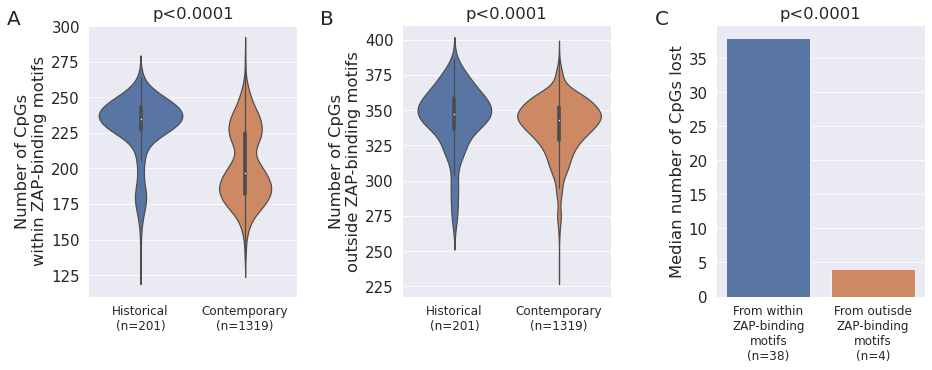

In [105]:
sns.set_context("paper", font_scale=1.7)
fig = plt.figure(figsize=(15, 5))
grid = plt.GridSpec(1, 3, wspace=0.5) #, hspace=0.5

v_a = fig.add_subplot(grid[0, 0])
v_b = fig.add_subplot(grid[0, 1])
v_c = fig.add_subplot(grid[0, 2])

# CpG within ZAP-binding motifs
g = sns.violinplot(
    x='hue',
    y='cpg_within_zap_motifs',
    data=df_plot[df_plot.hue != 'rest'],
    kind='violin',
    ax=v_a
)
g.set_xticklabels(["Historical\n(n=201)", "Contemporary\n(n=1319)"], fontsize=12)
g.set(xlabel="", ylabel="Number of CpGs\nwithin ZAP-binding motifs", title='p<0.0001')
v_a.text(0.05, 0.88, "A", transform=fig.transFigure, size=20) # weight="bold"

# CpG outside ZAP-binding motifs
g = sns.violinplot(
    x='hue',
    y='cpg_outside_zap_motifs',
    data=df_plot[df_plot.hue != 'rest'],
    kind='violin',
    ax=v_b
)
g.set_xticklabels(["Historical\n(n=201)", "Contemporary\n(n=1319)"], fontsize=12)
g.set(xlabel="", ylabel="Number of CpGs\noutside ZAP-binding motifs", title='p<0.0001')
v_b.text(0.34, 0.88, "B", transform=fig.transFigure, size=20)


# Barplot
g = sns.barplot(
    x=[0, 1],
    y=[38, 4],
    ax=v_c
)
g.set_xticklabels(["From within\nZAP-binding\nmotifs\n(n=38)", "From outisde\nZAP-binding\nmotifs\n(n=4)"], fontsize=12)
g.set(xlabel="", ylabel="Median number of CpGs lost", title="p<0.0001")
v_c.text(0.65, 0.88, "C", transform=fig.transFigure, size=20)

# plt.savefig("/content/drive/MyDrive/hcv_seq_analysis/plots/figure_03.png", dpi=300)

# Core protein region calculations using MSA

In [106]:
df_zap2 = DF.copy()


df_zap2['aln_seq'] = ''
df_zap2['aln_seq_len'] = 0

In [107]:
for row in df_zap2.itertuples():
    for a in alignment:
        if a.id == row.accession_id:
            df_zap2.at[row.Index, 'aln_seq'] = str(a.seq).upper()
            df_zap2.at[row.Index, 'aln_seq_len'] = len(a.seq)


In [108]:
xi = int(df_mapping[df_mapping['pre_aligned_number'] == 342]['aligned_number'])
xf = int(df_mapping[df_mapping['pre_aligned_number'] == 914]['aligned_number'])


df_zap2 = df_zap2.assign(
    aln_sub_seq=lambda x: x.seq.str[xi:xf]
)

In [109]:
def zap_n_motif_constructor(m):
    """Constructs the pattern for ZAP-binding motif given n
    Input: m is the m in C(n_{m})G(n)CG, where m = 4/5/6/7/8
    Returns the raw string for the desired ZAP-binding motif 
    """
    zap_motif = r"[cC]-*"
    for i in range(m):
        zap_motif = zap_motif + r"[aAtTcCgG]-*"
    return zap_motif + r"[gG]-*[aAtTcCgG]-*[cC]-*[gG]"


df_zap2 = df_zap2.assign(
    sub_seq_zap_motif_count=lambda x: x.aln_sub_seq.str.count(rf"{zap_n_motif_constructor(4)}") + x.aln_sub_seq.str.count(rf"{zap_n_motif_constructor(5)}") + x.aln_sub_seq.str.count(rf"{zap_n_motif_constructor(6)}") + x.aln_sub_seq.str.count(rf"{zap_n_motif_constructor(7)}") + x.aln_sub_seq.str.count(rf"{zap_n_motif_constructor(8)}")
)

df_zap2 = df_zap2.assign(
    sub_seq_cpg_count=lambda x: x.aln_sub_seq.str.count(r"[cC]-*[gG]")
)


def calc_obye(s):
    temp_s = s.replace('-', '').upper()
    return (len(temp_s) * temp_s.count('CG')) / (temp_s.count('C') * temp_s.count('G'))


df_zap2 = df_zap2.assign(
    sub_seq_obye=df_zap2.aln_sub_seq.apply(calc_obye)
)

In [110]:
df_zap2['hue'] = 'rest'

for row in df_zap2.itertuples():
    if row.year in bin1_years:
        df_zap2.at[row.Index, 'hue'] = 'Historical'
    elif row.year in bin2_years:
        df_zap2.at[row.Index, 'hue'] = 'Contemporary'
    else:
        pass

## Mann-Whitney U test

In [111]:
# CpG Numbers
U, p = mannwhitneyu(
    df_zap2[df_zap2.hue == 'Historical']['sub_seq_cpg_count'], 
    df_zap2[df_zap2.hue == 'Contemporary']['sub_seq_cpg_count'], 
    alternative='two-sided'
)
print(f'num13p={p}')

# CpG O/E
U, p = mannwhitneyu(
    df_zap2[df_zap2.hue == 'Historical']['sub_seq_obye'], 
    df_zap2[df_zap2.hue == 'Contemporary']['sub_seq_obye'], 
    alternative='two-sided'
)
print(f'obye13p={p}')

# ZAP-binding motifs
U, p = mannwhitneyu(
    df_zap2[df_zap2.hue == 'Historical']['sub_seq_zap_motif_count'], 
    df_zap2[df_zap2.hue == 'Contemporary']['sub_seq_zap_motif_count'], 
    alternative='two-sided'
)
print(f'zap13p={p}')

num13p=4.153306738186481e-43
obye13p=1.8102124228135507e-36
zap13p=1.2924685894018143e-07


In [112]:
print(len(df_zap2[df_zap2.hue == 'Historical']))
print(len(df_zap2[df_zap2.hue == 'Contemporary']))
print(len(df_zap2[df_zap2.hue == 'rest']))

201
1319
1097


In [113]:
print(df_zap2[df_zap2.hue == 'Historical'].sub_seq_cpg_count.median())
print(df_zap2[df_zap2.hue == 'Contemporary'].sub_seq_cpg_count.median())
print(df_zap2[df_zap2.hue == 'Historical'].sub_seq_obye.median())
print(df_zap2[df_zap2.hue == 'Contemporary'].sub_seq_obye.median())
print(df_zap2[df_zap2.hue == 'Historical'].sub_seq_zap_motif_count.median())
print(df_zap2[df_zap2.hue == 'Contemporary'].sub_seq_zap_motif_count.median())

43.0
31.0
0.728019801980198
0.5968586387434555
14.0
12.0


## Figure 5

In [114]:
df_zap2[df_zap2.hue != 'rest']['hue'].value_counts()

Contemporary    1319
Historical       201
Name: hue, dtype: int64

Text(0.69, 0.46, 'G')

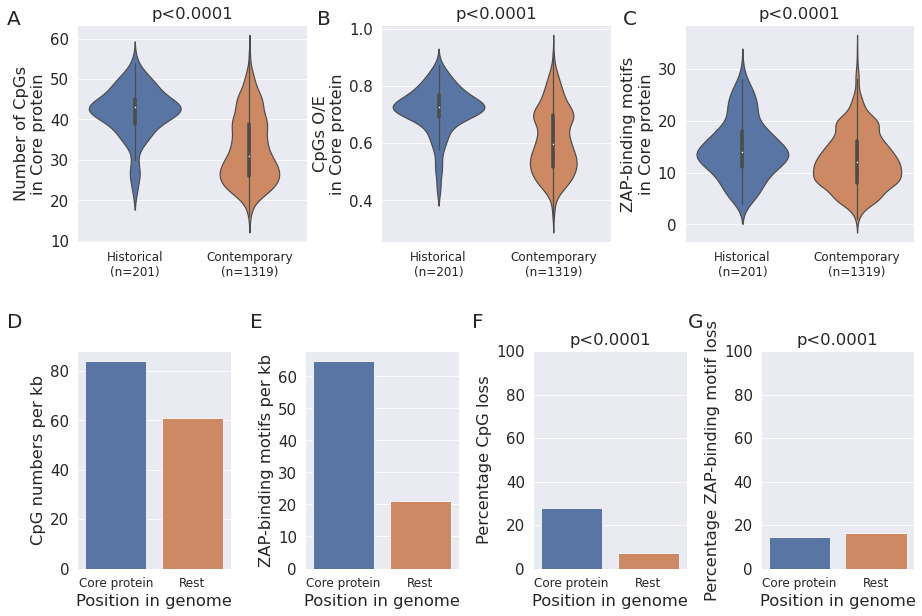

In [115]:
sns.set_context("paper", font_scale=1.7)
fig = plt.figure(figsize=(15, 10))
grid = plt.GridSpec(2, 12, wspace=50, hspace=0.5) 

v_a = fig.add_subplot(grid[0, 0:4])
v_b = fig.add_subplot(grid[0, 4:8])
v_c = fig.add_subplot(grid[0, 8:])
b_d = fig.add_subplot(grid[1, 0:3])
b_e = fig.add_subplot(grid[1, 3:6])
b_f = fig.add_subplot(grid[1, 6:9])
b_g = fig.add_subplot(grid[1, 9:])

# Number of CpGs in Core protein
g = sns.violinplot(
    x='hue',
    y='sub_seq_cpg_count',
    data=df_zap2[df_zap2.hue != 'rest'],
    kind='violin',
    ax=v_a
)
g.set_xticklabels(["Historical\n(n=201)", "Contemporary\n(n=1319)"], fontsize=12)
g.set(xlabel="", ylabel="Number of CpGs\nin Core protein", title='p<0.0001')
v_a.text(0.06, 0.88, "A", transform=fig.transFigure, size=20) # weight="bold"

# CpGs O/E in Core protein
g = sns.violinplot(
    x='hue',
    y='sub_seq_obye',
    data=df_zap2[df_zap2.hue != 'rest'],
    kind='violin',
    ax=v_b
)
g.set_xticklabels(["Historical\n(n=201)", "Contemporary\n(n=1319)"], fontsize=12)
g.set(xlabel="", ylabel="CpGs O/E\nin Core protein", title='p<0.0001')
v_b.text(0.347, 0.88, "B", transform=fig.transFigure, size=20)

# ZAP-binding motifs in Core protein
g = sns.violinplot(
    x='hue',
    y='sub_seq_zap_motif_count',
    data=df_zap2[df_zap2.hue != 'rest'],
    kind='violin',
    ax=v_c
)
g.set_xticklabels(["Historical\n(n=201)", "Contemporary\n(n=1319)"], fontsize=12)
g.set(xlabel="", ylabel="ZAP-binding motifs\nin Core protein", title='p<0.0001')
v_c.text(0.63, 0.88, "C", transform=fig.transFigure, size=20)
    

# Barplot
g = sns.barplot(
    x=[0, 1],
    y=[83.91608, 60.83315],
    ax=b_d
)
g.set_xticklabels(["Core protein", "Rest"], fontsize=12)
g.set(xlabel="Position in genome", ylabel="CpG numbers per kb")
b_d.text(0.06, 0.46, "D", transform=fig.transFigure, size=20)

# Barplot
g = sns.barplot(
    x=[0, 1],
    y=[64.68531, 21.04915],
    ax=b_e
)
g.set_xticklabels(["Core protein", "Rest"], fontsize=12)
g.set(xlabel="Position in genome", ylabel="ZAP-binding motifs per kb")
b_e.text(0.285, 0.46, "E", transform=fig.transFigure, size=20)

# Barplot
g = sns.barplot(
    x=[0, 1],
    y=[27.90698, 6.998158],
    ax=b_f
)
g.set_xticklabels(["Core protein", "Rest"], fontsize=12)
g.set(xlabel="Position in genome", ylabel="Percentage CpG loss", title="p<0.0001", ylim=(0, 100))
b_f.text(0.49, 0.46, "F", transform=fig.transFigure, size=20)

# Barplot
g = sns.barplot(
    x=[0, 1],
    y=[14.28571, 16.52893],
    ax=b_g
)
g.set_xticklabels(["Core protein", "Rest"], fontsize=12)
g.set(xlabel="Position in genome", ylabel="Percentage ZAP-binding motif loss", title="p<0.0001", ylim=(0, 100))
b_g.text(0.69, 0.46, "G", transform=fig.transFigure, size=20)



# plt.savefig("/content/drive/MyDrive/hcv_seq_analysis/plots/figure_05.png", dpi=300)

## Figure 4

In [116]:
df_fig4bc = pd.DataFrame({'nt_pos': range(1, len(ref_seq)+1)})

df_fig4bc['cpg_distribution'] = 0
df_fig4bc['zap_motifs_distribution'] = 0

zap_motif_counter = 0
for spacer in [4,5,6,7,8]:
    for zap_motif in re.finditer(zap_n_motif_constructor(spacer), ref_seq):
        zap_motif_counter += 1
        df_fig4bc.at[zap_motif.start(), 'zap_motifs_distribution'] += 1
    
print(zap_motif_counter)


cpg_counter = 0

for cpg in re.finditer(r"[cC]-*[gG]", ref_seq):
    cpg_counter += 1
    df_fig4bc.at[cpg.start(), 'cpg_distribution'] = 1

print(cpg_counter)

258
597


In [117]:
df_zap.iloc[0]

accession_id                                               NC_004102.1
seq                  GCCAGCCCCCTGATGGGGGCGACACTCCACCATGAATCACTCCCCT...
seq_len                                                           9646
year                                                               NaN
zap_4_motif_count                                                   39
zap_5_motif_count                                                   51
zap_6_motif_count                                                   63
zap_7_motif_count                                                   56
zap_8_motif_count                                                   49
zap_motifs                                                         258
Name: 0, dtype: object

In [118]:
df_zap2.iloc[0]

accession_id                                                     NC_004102.1
seq                        GCCAGCCCCCTGATGGGGGCGACACTCCACCATGAATCACTCCCCT...
seq_len                                                                 9646
collection_date                                                          NaN
strain                                                                   NaN
isolate                                                                  H77
country                                                                  NaN
genotype                   assembled from cDNA library representing a pop...
organism                                        Hepatitis C virus genotype 1
header                         Hepatitis C virus genotype 1, complete genome
cpg_count                                                                597
cpg_per                                                             6.189094
cpg_obye                                                            0.730745

In [119]:
# df_fig4bc[df_fig4bc['zap_motifs_distribution'] > 1]
print(df_fig4bc['zap_motifs_distribution'].sum())
print(df_fig4bc['cpg_distribution'].sum())

258
597


In [120]:
df_fig4bc['MA_zap_motifs_distribution'] = df_fig4bc['zap_motifs_distribution'].rolling(window=500, closed='both', center=True).sum()
df_fig4bc['MA_cpg_distribution'] = df_fig4bc['cpg_distribution'].rolling(window=500, closed='both', center=True).sum()

# closed='both', center=True
df_fig4bc

,nt_pos,cpg_distribution,zap_motifs_distribution,MA_zap_motifs_distribution,MA_cpg_distribution
0,1,0,0,NaN,NaN
1,2,0,0,NaN,NaN
2,3,0,0,NaN,NaN
3,4,0,0,NaN,NaN
4,5,0,0,NaN,NaN
...,...,...,...,...,...
9641,9642,0,0,NaN,NaN
9642,9643,0,0,NaN,NaN
9643,9644,0,0,NaN,NaN
9644,9645,0,0,NaN,NaN


In [121]:
df_fig4bc

,nt_pos,cpg_distribution,zap_motifs_distribution,MA_zap_motifs_distribution,MA_cpg_distribution
0,1,0,0,NaN,NaN
1,2,0,0,NaN,NaN
2,3,0,0,NaN,NaN
3,4,0,0,NaN,NaN
4,5,0,0,NaN,NaN
...,...,...,...,...,...
9641,9642,0,0,NaN,NaN
9642,9643,0,0,NaN,NaN
9643,9644,0,0,NaN,NaN
9644,9645,0,0,NaN,NaN


In [122]:
def add_hcv_patches_to_plot(AX, legend_location, legend_font_size, ymax, legend_visibility=True, alpha_val=1):
    """"Input:
    AX- ax of the plot to which you want to add the patches to this it
    legend_location- arg to be set equal to bbox_to_anchor
    legend_font_size- font size of legend
    ymax- max value to be displayed on y-axis in the plot
    """
    # sns.color_palette("husl", 12)
    custom_palette = [
        '#1f77b4',
        '#ff9896',
        '#ff7f0e',
        '#ffbb78',
        '#d62728',
        '#2ca02c',
        '#98df8a',
        '#8c564b',
        '#e377c2',
        '#9467bd',
        '#c5b0d5',
        '#aec7e8'
    ]
    palette = iter(sns.color_palette(custom_palette, 12))
    # palette = iter(sns.mpl_palette('tab20', 12))
    # palette = iter(sns.husl_palette(12))
    # 5'-UTR ------------------------------------------------------------------------------
    rect5utr = mpatches.Rectangle(
        (1,0), 340, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth=1, label='5\'-UTR'
    )
    AX.add_patch(rect5utr)
    
    # Core protein ---------------------------------------------------------------------------
    rect1 = mpatches.Rectangle(
        (342,0), 572, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth=1, label='Core protein'
    )
    AX.add_patch(rect1)
    
    # Envelope protein E1 ------------------------------------------------------------------------------
    rect2 = mpatches.Rectangle(
        (915,0), 575, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth=1, label='Envelope protein E1'
    )
    AX.add_patch(rect2)
    
    # Envelope Protein E2 -----------------------------------------------------------------------------------
    rect3 = mpatches.Rectangle(
        (1491,0), 1088, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth = 1, label='Envelope Protein E2'
    )
    AX.add_patch(rect3)
    
    # Protein P7 ------------------------------------------------------------------------------
    rect4 = mpatches.Rectangle(
        (2580,0), 188, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth = 1, label='Protein P7'
    )
    AX.add_patch(rect4)
    
    # NS2 ------------------------------------------------------------------------------
    rect5 = mpatches.Rectangle(
        (2769,0), 650, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth = 1, label='NS2'
    )
    AX.add_patch(rect5)
    
    # NS3 ----------------------------------------------------------------------------------
    rect6 = mpatches.Rectangle(
        (3420,0), 1892, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth = 1, label='NS3'
    )
    AX.add_patch(rect6)
    
    # Cofactor NS3 ----------------------------------------------------------------------------------
    rect7 = mpatches.Rectangle(
        (5313,0), 161, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth=1, label='Cofactor NS3'
    )
    AX.add_patch(rect7)
    
    # Membrane protein ------------------------------------------------------------------------------
    rect8 = mpatches.Rectangle(
        (5475,0), 782, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth=1, label='Membrane protein'
    )
    AX.add_patch(rect8)
    
    # NS5A ------------------------------------------------------------------------------
    rect9 = mpatches.Rectangle(
        (6258,0), 1343, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth=1, label='NS5A'
    )
    AX.add_patch(rect9)
    
    # NS5B ------------------------------------------------------------------------------
    rect10 = mpatches.Rectangle(
        (7602,0), 1772, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth=1, label='NS5B'
    )
    AX.add_patch(rect10)
    
    # 3'-UTR ------------------------------------------------------------------------------
    rect3utr = mpatches.Rectangle(
        (9378,0), 268, 100, fill=True, color=next(palette), alpha=alpha_val, linewidth=1, label='3\'-UTR'
    )
    AX.add_patch(rect3utr)
    
    if legend_visibility:
        plt.legend(
            handles=[
                rect5utr, 
                rect1, 
                rect2, 
                rect3, 
                rect4, 
                rect5, 
                rect6, 
                rect7, 
                rect8, 
                rect9, 
                rect10, 
                rect3utr
            ], 
            bbox_to_anchor=legend_location, 
            fontsize=legend_font_size, 
            frameon=False,
            ncol=3
        )

In [123]:
pd.concat(
        [
            df_zap4,
            df_zap5, 
            df_zap6, 
            df_zap7, 
            df_zap8
        ]
    ).reset_index(drop=True).to_csv('zap_binding_motif_data_for_fig4a.csv', index=False)

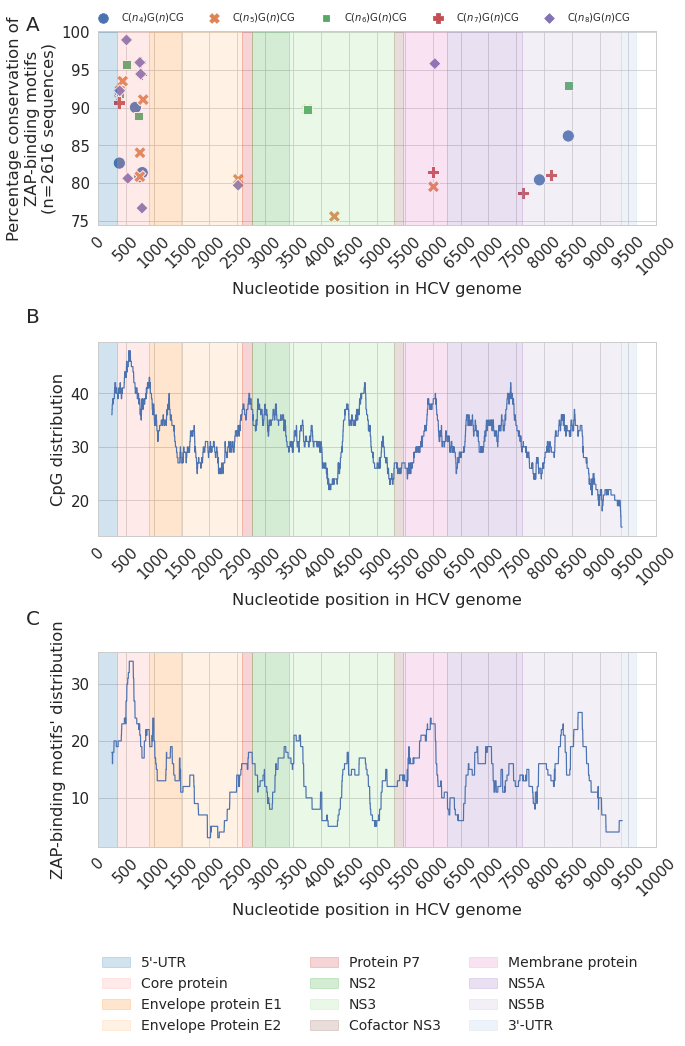

In [124]:
# sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
fig = plt.figure(figsize=(10, 15))
grid = plt.GridSpec(3, 1, hspace=0.6) #wspace=0.5,

l_a = fig.add_subplot(grid[0, 0], )
l_b = fig.add_subplot(grid[1, 0], sharex=l_a)
l_c = fig.add_subplot(grid[2, 0], sharex=l_a)


# Percentage conservation scatterplot
g = sns.scatterplot(
    data=pd.concat(
        [
            df_zap4,
            df_zap5, 
            df_zap6, 
            df_zap7, 
            df_zap8
        ]
    ).reset_index(drop=True),
    x='zap_binding_motif_position',
    y='percentage',
    hue='motif',
    style='motif',
    s=150,
    alpha=1,
    ax=l_a
)

g.set(
    xlabel='Nucleotide position in HCV genome', 
    ylabel='Percentage conservation of\nZAP-binding motifs\n(n=2616 sequences)',
    xlim=(0,10000)
)
g.xaxis.set_major_locator(ticker.MultipleLocator(500))
g.xaxis.set_major_formatter(ticker.ScalarFormatter())
g.tick_params(axis='x', rotation=45)
g.legend(ncol=5, loc="upper left", bbox_to_anchor=(-0.025, 1.15), frameon=False, markerscale=2, fontsize=10)
l_a.text(0.025, 0.88, "A", transform=fig.transFigure, size=20)
add_hcv_patches_to_plot(
    g, legend_location=(0.005, 0.005), legend_font_size=20, ymax=100, legend_visibility=False, alpha_val=0.2
)

# CpG distribution
g = sns.lineplot(
    data=df_fig4bc,
    x='nt_pos',
    y='MA_cpg_distribution',
    ax=l_b
)
g.set(
    xlabel='Nucleotide position in HCV genome', 
    ylabel='CpG distribution',
    xlim=(0,10000)
)
g.xaxis.set_major_locator(ticker.MultipleLocator(500))
g.xaxis.set_major_formatter(ticker.ScalarFormatter())
g.tick_params(axis='x', rotation=45)
l_b.text(0.025, 0.61, "B", transform=fig.transFigure, size=20)
add_hcv_patches_to_plot(
    g, legend_location=(0.005, 0.005), legend_font_size=20, ymax=100, legend_visibility=False, alpha_val=0.2
)

# ZAP-binding motifs' distribution
g = sns.lineplot(
    data=df_fig4bc,
    x='nt_pos',
    y='MA_zap_motifs_distribution',
)
g.set(
    xlabel='Nucleotide position in HCV genome', 
    ylabel='ZAP-binding motifs\' distribution',
    xlim=(0,10000)
)
g.xaxis.set_major_locator(ticker.MultipleLocator(500))
g.xaxis.set_major_formatter(ticker.ScalarFormatter())
g.tick_params(axis='x', rotation=45)
l_c.text(0.025, 0.33, "C", transform=fig.transFigure, size=20)

add_hcv_patches_to_plot(
    g, legend_location=(0.99, -0.5), legend_font_size=14, ymax=100, legend_visibility=True, alpha_val=0.2
)

# plt.savefig("/content/drive/MyDrive/hcv_seq_analysis/plots/figure_04.png", dpi=300, bbox_inches='tight')

In [125]:
# import matplotlib.colors

# for c in plt.cm.tab20.colors: 
#     print(matplotlib.colors.to_hex(c))

# palette = [
#     '#1f77b4',
#     '#ff9896',
#     '#ff7f0e',
#     '#ffbb78',
#     '#d62728',
#     '#2ca02c',
#     '#98df8a',
#     '#c49c94',
#     '#e377c2',
#     '#9467bd',
#     '#c5b0d5',
#     '#aec7e8'
# ]

# Unmount Drive and save changes

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
